In [ ]:
# !pip install scipy
# !pip install statsmodels

In [1]:
#from google.colab import files
import pandas as pd
import numpy as np
import calendar
# import warnings
from scipy.stats import spearmanr, kendalltau
from scipy.stats import entropy
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

### Cargando rutas de archivos y funciones

In [2]:
# Cargamos el archivo Excel - RFF Procesado
# --------------

ruta_path = 'C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS'               # -> Casa
# ruta_path = 'C:/Users/usuario/Documents/DOCUMENTOS_CONSULTOR_5_BI'      # -> Trabajo


ruta_path_fabrica = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_fabrica_full.csv'
ruta_path_balanza = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_participacion_full.csv'
ruta_path_saldo_campo = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_saldo_campo_full_vf.csv'
ruta_calidad_precipitacion = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_calidad_precipitacion_full.csv'
# --
ruta_calidad_racimos_propios = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_calidad_racimos_propios_total_full.csv'
ruta_antiguedad_frutos = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_antiguedad_fruta_full.csv'
# --
ruta_calidad_racimos_terceros = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_calidad_terceros_full.csv'
# --
ruta_acidez = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_acidez_full.csv'
# --
ruta_clima = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_clima_full_vf.csv'
# --
ruta__freq_cosecha = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_freq_cosecha_full.csv'
# --
ruta_participacion_cashcost_full = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_participacion_cashcost_full.csv'
# --
ruta_perdida_aceite_full = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_perdida_aceite_full.csv'
# --
ruta_perdida_cosecha = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_perdida_otros_full_group.csv'




In [65]:
## FUNCION COMPLETITUD
## #######################
## #######################
## #######################

def function_completitud(df_x, variable, valor = 2, anio_filtro = '1901-01-01'):
    # Mostrando estadísticas importantes

    # --- Seleccionamos PLANTACION
    # ---
    df_bbdd_imputar = df_x
    plantacion_name = df_bbdd_imputar['PLANTACION'].unique()

    # Crear una nueva columna con el año y mes en el formato deseado
    df_bbdd_imputar['FECHA'] = pd.to_datetime(df_bbdd_imputar['FECHA'])

    # Crear un rango de fechas que cubra el período completo del DataFrame original
    start_date = df_bbdd_imputar['FECHA'].min().replace(day=1)
    end_date = (df_bbdd_imputar['FECHA'].max() + pd.offsets.MonthEnd(1)).replace(day=1) - pd.Timedelta(days=1)
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Crear un DataFrame con todas las fechas
    df_all_dates = pd.DataFrame(all_dates, columns=['FECHA'])
    # Hacer un merge con el DataFrame original
    df_merged = pd.merge(df_all_dates, df_bbdd_imputar, on='FECHA', how='left')

    # Filtramos el año si es que fuera necesario
    # ---
    # Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
    fecha_limite = pd.Timestamp(anio_filtro)
    df_merged = df_merged[df_merged['FECHA'] > fecha_limite]

    # Crear las columnas variable_con_datos y variable_sin_datos
    df_merged['variable_con_datos'] = np.where(df_merged[variable].notnull() & (df_merged[variable] != 0), 1, 0)
    df_merged['variable_sin_datos'] = np.where(df_merged[variable].isnull() | (df_merged[variable] == 0), 1, 0)

    # Agrupar por mes y sumar las columnas
    df_merged['AÑO_MES'] = df_merged['FECHA'].dt.strftime('%Y-%m')
    df_monthly = df_merged.groupby('AÑO_MES').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_monthly['PLANTACION'] = plantacion_name[0]
    df_monthly['Total_dias'] = df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos']
    df_monthly['% Completitud'] = df_monthly['variable_con_datos']/(df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos'])

    # Agrupar por año
    df_merged['AÑO'] = df_merged['FECHA'].dt.strftime('%Y')
    df_year = df_merged.groupby('AÑO').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_year['PLANTACION'] = plantacion_name[0]
    df_year['Total_dias'] = df_year['variable_con_datos'] + df_year['variable_sin_datos']
    df_year['% Completitud'] = df_year['variable_con_datos']/(df_year['variable_con_datos'] + df_year['variable_sin_datos'])

    # Creando el indicador divergencia KL (Kullback-Leibler)
    # ------
    df_merged['incompleto'] = df_merged[variable]
    df_merged['completo'] = df_merged[variable]

    # Reemplazamos los ceros por NaN

    df_merged['completo'].replace(0, np.nan, inplace=True)
    df_merged['completo'].fillna(method='ffill', inplace=True) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular la moda de cada columna
    # moda_variable = df_merged['completo'].mode().iloc[0]

    # Verificar si la moda no está vacía antes de acceder al primer elemento
    if not df_merged['completo'].mode().empty:
        moda_variable = df_merged['completo'].mode().iloc[0]
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por la moda
    else:
        # Si no hay moda, calcular el promedio
        moda_variable = df_merged['completo'].mean()
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el promedio


    df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular las distribuciones de la variable original y la imputada
    hist_original, bin_edges = np.histogram(df_merged['incompleto'].dropna(), bins=30, density=True)
    hist_imputado, _ = np.histogram(df_merged['completo'], bins=bin_edges, density=True)

    # Calcular la divergencia KL entre las dos distribuciones
    kl_divergence = entropy(hist_original, hist_imputado)


    # Guardamos el datframe - df_monthly
    # -----
    print( "## ################# ##")
    print(f'Divergencia KL: {kl_divergence}')
    print(f'Dataframe creados: df_year, df_month')
    print( "## ################# ##")

    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_mensual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_month.xlsx'  # Cambia esta ruta a la que necesites
    df_monthly.to_excel(ruta_path + ruta_missing_mensual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_mensual}')

    # Guardamos el datframe - df_year
    # -----
    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_anual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_year.xlsx'  # Cambia esta ruta a la que necesites
    df_year.to_excel(ruta_path + ruta_missing_anual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_anual}')

     # Mostrar el DataFrame correspondiente según el valor de `val`
    if valor == 1:
        print("DataFrame df_year:")
        print(df_year.head(10))
    else:
        print("DataFrame df_month:")
        print(df_monthly.head(10))



## FUNCION COMPLETITUD PENALIZADA
## #######################
## #######################
## #######################

def function_completitud_pen(df_x, variable, valor = 2, anio_filtro = '1901-01-01'):
    # Mostrando estadísticas importantes

    # --- Seleccionamos PLANTACION
    # ---
    df_bbdd_imputar = df_x
    plantacion_name = df_bbdd_imputar['PLANTACION'].unique()

    # Crear una nueva columna con el año y mes en el formato deseado
    df_bbdd_imputar['FECHA'] = pd.to_datetime(df_bbdd_imputar['FECHA'])

    # Crear un rango de fechas que cubra el período completo del DataFrame original
    start_date = df_bbdd_imputar['FECHA'].min().replace(day=1)
    end_date = (df_bbdd_imputar['FECHA'].max() + pd.offsets.MonthEnd(1)).replace(day=1) - pd.Timedelta(days=1)
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Crear un DataFrame con todas las fechas
    df_all_dates = pd.DataFrame(all_dates, columns=['FECHA'])
    # Hacer un merge con el DataFrame original
    df_merged = pd.merge(df_all_dates, df_bbdd_imputar, on='FECHA', how='left')
    df_merged['FECHA'] = pd.to_datetime(df_merged['FECHA'])
    dim_start = df_merged.shape[0]

    # Filtrar filas donde el día de la semana no sea domingo (domingo es 6)
    df_merged = df_merged[df_merged['FECHA'].dt.weekday != 6]
    df_merged = df_merged[df_merged['FECHA'].dt.weekday != 5]

    dim_finish = df_merged.shape[0]

    dim_reduccion = dim_finish/dim_start

    # Filtramos el año si es que fuera necesario
    # ---
    # Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
    fecha_limite = pd.Timestamp(anio_filtro)
    df_merged = df_merged[df_merged['FECHA'] > fecha_limite]

    # Crear las columnas variable_con_datos y variable_sin_datos
    df_merged['variable_con_datos'] = np.where(df_merged[variable].notnull() & (df_merged[variable] != 0), 1, 0)
    df_merged['variable_sin_datos'] = np.where(df_merged[variable].isnull() | (df_merged[variable] == 0), 1, 0)

    sum_variable_con_datos = df_merged['variable_con_datos'].sum()
    sum_variable_sin_datos = df_merged['variable_sin_datos'].sum()
    pctj_completitud_total = sum_variable_con_datos/(sum_variable_con_datos + sum_variable_sin_datos)

    # Agrupar por mes y sumar las columnas
    df_merged['AÑO_MES'] = df_merged['FECHA'].dt.strftime('%Y-%m')
    df_monthly = df_merged.groupby('AÑO_MES').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_monthly['PLANTACION'] = plantacion_name[0]
    df_monthly['Total_dias'] = df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos']
    df_monthly['% Completitud'] = df_monthly['variable_con_datos']/(df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos'])

    # Agrupar por año
    df_merged['AÑO'] = df_merged['FECHA'].dt.strftime('%Y')
    df_year = df_merged.groupby('AÑO').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_year['PLANTACION'] = plantacion_name[0]
    df_year['Total_dias'] = df_year['variable_con_datos'] + df_year['variable_sin_datos']
    df_year['% Completitud'] = df_year['variable_con_datos']/(df_year['variable_con_datos'] + df_year['variable_sin_datos'])

    # Creando el indicador divergencia KL (Kullback-Leibler)
    # ------
    df_merged['incompleto'] = df_merged[variable]
    df_merged['completo'] = df_merged[variable]

    # Reemplazamos los ceros por NaN

    df_merged['completo'].replace(0, np.nan, inplace=True)
    df_merged['completo'].fillna(method='ffill', inplace=True) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular la moda de cada columna
    # moda_variable = df_merged['completo'].mode().iloc[0]

    # Verificar si la moda no está vacía antes de acceder al primer elemento
    if not df_merged['completo'].mode().empty:
        moda_variable = df_merged['completo'].mode().iloc[0]
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por la moda
    else:
        # Si no hay moda, calcular el promedio
        moda_variable = df_merged['completo'].mean()
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el promedio


    df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular las distribuciones de la variable original y la imputada
    hist_original, bin_edges = np.histogram(df_merged['incompleto'].dropna(), bins=30, density=True)
    hist_imputado, _ = np.histogram(df_merged['completo'], bins=bin_edges, density=True)

    # Calcular la divergencia KL entre las dos distribuciones
    kl_divergence = entropy(hist_original, hist_imputado)


    # Guardamos el datframe - df_monthly
    # -----
    print( "## ################# ##")
    print(f'Divergencia KL: {kl_divergence}')
    print(f'Sin considerar dias sábados/domingos: {dim_reduccion}')
    print(f'Dataframe creados: df_year, df_month')
    print(f'pctj_completitud_total= {pctj_completitud_total}')
    print( "## ################# ##")

    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_mensual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_month.xlsx'  # Cambia esta ruta a la que necesites
    df_monthly.to_excel(ruta_path + ruta_missing_mensual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_mensual}')

    # Guardamos el datframe - df_year
    # -----
    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_anual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_year.xlsx'  # Cambia esta ruta a la que necesites
    df_year.to_excel(ruta_path + ruta_missing_anual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_anual}')

     # Mostrar el DataFrame correspondiente según el valor de `val`
    if valor == 1:
        print("DataFrame df_year:")
        print(df_year.head(10))
    else:
        print("DataFrame df_month:")
        print(df_monthly.head(10))






## FUNCION GRAFICADORA 1
## #######################
## #######################
## #######################

def function_tendencia_unica(df_x, valor,colors='green'):
    df_x = df_x.sort_values(by='FECHA')
    plantacion_name = df_x['PLANTACION'].unique()

    plt.figure(figsize=(15, 5))
    plt.plot(df_x['FECHA'], df_x[valor], marker='o', markersize=2, linestyle='-', color=colors, label='Pesos')
    plt.title(f'{plantacion_name[0]}: variable {valor} - a través del Tiempo ')
    plt.xlabel('Fecha')
    plt.ylabel('Pesos')
    plt.grid(True)
    plt.legend()
    #plt.xticks(rotation=45)

    fecha_min = df_x['FECHA'].min()
    fecha_max = df_x['FECHA'].max()
    print('Analisis de ', fecha_min, ' hasta ', fecha_max)
    
    # Mostrar la gráfica
    # print(df_TEA_full_tendencia[df_TEA_full_tendencia['RFF PROCESADO'] == 0].head())
    plt.tight_layout()
    plt.show()




## FUNCION SAVE EXCEL
## #######################
## #######################
## #######################

def function_save(df_x):
    # Especifica la ruta donde deseas guardar el CSV
    ruta_save =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/__bbdd_revision__.xlsx'  # Cambia esta ruta a la que necesites
    df_x.to_excel(ruta_path + ruta_save, index=False)
    print(f'Datos guardados en {ruta_path + ruta_save}')



### Cargando datos processed

In [4]:
### Cargamos df_sabana_fabrica_full
### --------------------
df_sabana_fabrica_full = pd.read_csv(ruta_path + ruta_path_fabrica)
df_sabana_balanza_full = pd.read_csv(ruta_path + ruta_path_balanza)

df_sabana_saldo_campo_full_vf = pd.read_csv(ruta_path + ruta_path_saldo_campo)
df_sabana_saldo_campo_full_vf['FECHA'] = pd.to_datetime(df_sabana_saldo_campo_full_vf['FECHA'])

df_calidad_precipitacion_full = pd.read_csv(ruta_path + ruta_calidad_precipitacion)
df_calidad_precipitacion_full['FECHA'] = df_calidad_precipitacion_full['FECHA'].str.split(' ').str[0]
df_calidad_precipitacion_full['FECHA'] = pd.to_datetime(df_calidad_precipitacion_full['FECHA'], format='%Y-%m-%d')

# --
df_calidad_racimos_propios_full = pd.read_csv(ruta_path + ruta_calidad_racimos_propios)
df_calidad_antiguedad_frutos_full = pd.read_csv(ruta_path + ruta_antiguedad_frutos)

# --
df_sabana_calidad_terceros_full = pd.read_csv(ruta_path + ruta_calidad_racimos_terceros)
df_sabana_calidad_terceros_full['FECHA'] = pd.to_datetime(df_sabana_calidad_terceros_full['FECHA'], format='%Y-%m-%d')
df_sabana_calidad_terceros_full['% VERDES'] = df_sabana_calidad_terceros_full['% VERDES'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% MADUROS'] = df_sabana_calidad_terceros_full['% MADUROS'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% SMADUROS'] = df_sabana_calidad_terceros_full['% SMADUROS'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% ESCOBAJO'] = df_sabana_calidad_terceros_full['% ESCOBAJO'].replace('-',np.nan)

df_sabana_calidad_terceros_full['% VERDES'] = df_sabana_calidad_terceros_full['% VERDES'].astype(float)
df_sabana_calidad_terceros_full['% MADUROS'] = df_sabana_calidad_terceros_full['% MADUROS'].astype(float)
df_sabana_calidad_terceros_full['% SMADUROS'] = df_sabana_calidad_terceros_full['% SMADUROS'].astype(float)
df_sabana_calidad_terceros_full['% ESCOBAJO'] = df_sabana_calidad_terceros_full['% ESCOBAJO'].astype(float)

# --
df_acidez_full = pd.read_csv(ruta_path + ruta_acidez)

# --
df_clima_full_vf = pd.read_csv(ruta_path + ruta_clima)

# --
df_freq_cosecha_full = pd.read_csv(ruta_path + ruta__freq_cosecha)

# --
df_participacion_cashcost_full = pd.read_csv(ruta_path + ruta_participacion_cashcost_full)

# --
df_perdida_aceite_full = pd.read_csv(ruta_path + ruta_perdida_aceite_full)
df_perdida_aceite_full['FECHA'] = pd.to_datetime(df_perdida_aceite_full['FECHA'])

# --
df_perdida_cosecha_full_vf = pd.read_csv(ruta_path + ruta_perdida_cosecha)


### Visualizando datos/ completitud de datos

In [ ]:
# df_sabana_fabrica_full.head(15)
# df_sabana_balanza_full.head()       # --> se actualizará con la data de Rolly (CashCost)

# df_sabana_saldo_campo_full_vf.head()

# print(df_calidad_precipitacion_full.dtypes)
# df_calidad_precipitacion_full.head()

# df_calidad_racimos_propios_full.head()
# df_calidad_antiguedad_frutos_full.head()

# df_acidez_full.head()
df_perdida_aceite_full.head()


In [ ]:
df_sabana_fabrica_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                  'MES_NRO':'count'})

In [ ]:
df_sabana_balanza_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                  'PTANIO':'count'})

In [ ]:
df_sabana_saldo_campo_full_vf.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                        'SALDO':'count'})

In [150]:
df_calidad_precipitacion_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                         'PLANTACION':'count'})

FECHA            PLANTACION
                       min        max      count
PLANTACION                                      
Nuevo Horizonte 2019-01-01 2024-03-17       1870
Palmawasi       2019-01-01 2024-03-17       1903
Shanuzi         2006-08-01 2024-04-05       6457
Tulumayo        2022-01-01 2024-04-15        836

In [ ]:
df_calidad_racimos_propios_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                           'PLANTACION':'count'})

In [ ]:
df_sabana_calidad_terceros_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                           'PLANTACION':'count'})

In [ ]:
df_calidad_antiguedad_frutos_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                             'PLANTACION':'count'})

In [ ]:
df_acidez_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                          'PLANTACION':'count'})

In [ ]:
df_clima_full_vf.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                            'PLANTACION':'count'})

In [ ]:
df_freq_cosecha_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                'PLANTACION':'count'})

In [ ]:
df_participacion_cashcost_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                          'PLANTACION':'count'})

In [ ]:
df_perdida_aceite_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                  'PLANTACION':'count'})

In [ ]:
df_perdida_cosecha_full_vf.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                      'PLANTACION':'count'})

##### --------------------------------------------

In [ ]:
df_clima_full_vf.head()
#df_participacion_cashcost_full.dtypes

In [ ]:
df_clima_full_vf.groupby('PLANTACION').size()

In [ ]:
function_completitud_pen(df_clima_full_vf[df_clima_full_vf['PLANTACION'] == 'Nuevo Horizonte'],'Temp Hi',1)

In [ ]:
# df_sabana_fabrica_full.groupby('PLANTACION').size()
# df_sabana_balanza_full.groupby('PLANTACION').size()
# df_sabana_saldo_campo_full_vf.groupby('PLANTACION').size()
# df_calidad_precipitacion_full.groupby('PLANTACION').size()


##### Transformando datos

In [ ]:
# AÑADIENDO DATOS DE BALANZA Y FABRICA
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full = pd.merge(df_sabana_balanza_full[['FECHA','PLANTACION','PROPIOS','TERCEROS','TOTAL','PARTICIPACION CP']], 
                       df_sabana_fabrica_full[['FECHA','PLANTACION','RFF PROCESADO','CPO OBTENIDO','TEA']], 
                       on=['FECHA', 'PLANTACION'], how='outer')
# Convertir 'FECHA' a formato datetime
df_TEA_full['FECHA'] = pd.to_datetime(df_TEA_full['FECHA'])


print(f'df_sabana_balanza_full: {df_sabana_balanza_full.shape}')
print(f'df_sabana_fabrica_full: {df_sabana_fabrica_full.shape}')

print(df_TEA_full['PLANTACION'].unique())
print(f'df_TEA_full: {df_TEA_full.shape}')
df_TEA_full.head(15)

In [ ]:
# AÑADIENDO DATOS DE PRECIPITACION
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full = pd.merge(df_TEA_full, 
                       df_calidad_precipitacion_full, 
                       on=['FECHA', 'PLANTACION'], how='outer')

# Convertir 'FECHA' a formato datetime
df_TEA_full['FECHA'] = pd.to_datetime(df_TEA_full['FECHA'])

print(df_TEA_full['PLANTACION'].unique())
print(f'df_TEA_full: {df_TEA_full.shape}')
df_TEA_full.head(15)

In [ ]:
function_tendencia_unica(df_TEA_full[df_TEA_full['PLANTACION'] == 'Palmawasi'], 'TERCEROS')

In [ ]:
# AÑADIENDO DATOS DE CALIDAD RACIMOS PROPIOS
# #######################
# #######################

df_calidad_racimos_propios_full.tail()
# df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Palmawasi'].tail(15)


In [ ]:
df_calidad_racimos_propios_full_group = df_calidad_racimos_propios_full.groupby(['FECHA','PLANTACION','SECTOR']).agg({'VERDES':'sum',
                                                                                                                      'MADUROS':'sum',
                                                                                                                      'SMADUROS':'sum',
                                                                                                                      'PEDUNCULO':'sum',
                                                                                                                      'ESCOBAJO':'sum',
                                                                                                                      'MALFORMADOA':'sum',
                                                                                                                      'MALFORMADOB': 'sum',
                                                                                                                      'Peso':'sum',
                                                                                                                      'Racimos':'sum'}).reset_index()

# Validamos presencia de duplicados en la bbdd
df_prueba = df_calidad_racimos_propios_full[['FECHA','PLANTACION','SECTOR']].drop_duplicates()
print(df_calidad_racimos_propios_full.shape)
print(df_prueba.shape)

# Creando variables de calidad
df_calidad_racimos_propios_full_group['Peso_CALIDAD'] = df_calidad_racimos_propios_full_group[['VERDES','MADUROS','SMADUROS','PEDUNCULO','ESCOBAJO']].sum(axis=1)

df_calidad_racimos_propios_full_group['Peso_VERDES'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['VERDES']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])
df_calidad_racimos_propios_full_group['Peso_MADUROS'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['MADUROS']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])
df_calidad_racimos_propios_full_group['Peso_SMADUROS'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['SMADUROS']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])
df_calidad_racimos_propios_full_group['Peso_PEDUNCULO'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['PEDUNCULO']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])
df_calidad_racimos_propios_full_group['Peso_ESCOBAJO'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['ESCOBAJO']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])

# print(df_calidad_racimos_propios_full_group['PLANTACION'].unique())

# Craendo dataframe agrupando los sectores
# ------------
df_agg_racimos = df_calidad_racimos_propios_full_group.groupby(['FECHA','PLANTACION']).agg({'Peso_VERDES':'sum',
                                                                                            'Peso_MADUROS':'sum',
                                                                                            'Peso_SMADUROS':'sum',
                                                                                            'Peso_PEDUNCULO':'sum',
                                                                                            'Peso_ESCOBAJO':'sum',
                                                                                            'Peso':'sum',
                                                                                            'Racimos':'sum'}).reset_index()
df_agg_racimos['FECHA'] = pd.to_datetime(df_agg_racimos['FECHA'])

print(df_agg_racimos['PLANTACION'].unique())
df_agg_racimos.tail()


In [ ]:
# AÑADIENDO DATOS DE PRECIPITACION
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full = pd.merge(df_TEA_full, 
                       df_agg_racimos, 
                       on=['FECHA', 'PLANTACION'], how='outer')

# Convertir 'FECHA' a formato datetime
df_TEA_full['FECHA'] = pd.to_datetime(df_TEA_full['FECHA'])

print(df_TEA_full['PLANTACION'].unique())
print(f'df_TEA_full: {df_TEA_full.shape}')
df_TEA_full.head()

In [ ]:
function_tendencia_unica(df_agg_racimos[df_agg_racimos['PLANTACION'] == 'Palmawasi'], 'Peso')

#### Analizando tendencias

##### ACIDEZ VS CALIDAD RACIMOS PROPIOS

In [7]:
df_acidez_full.head()

,FECHA,PLANTACION,% Acidez
0,2021-12-19,Tulumayo,1.930
1,2023-01-01,Nuevo Horizonte,NaN
2,2023-01-01,Palmawasi,NaN
3,2023-01-02,Nuevo Horizonte,2.650
4,2023-01-02,Palmawasi,2.475


In [8]:
df_acidez_full.PLANTACION.unique()

array(['Tulumayo', 'Nuevo Horizonte', 'Palmawasi', 'Shanuzi'],
      dtype=object)

In [43]:
# df_acidez_full[df_acidez_full['PLANTACION'] == 'Shanuzi'].tail()
df_acidez_full[df_acidez_full['PLANTACION'] == 'Palmawasi'].tail()


,FECHA,PLANTACION,% Acidez
1452,2024-06-25,Palmawasi,2.718333
1455,2024-06-26,Palmawasi,2.081667
1458,2024-06-27,Palmawasi,2.025000
1461,2024-06-28,Palmawasi,2.025000
1464,2024-06-29,Palmawasi,1.913333


Analisis de  2023-01-01  hasta  2024-06-29


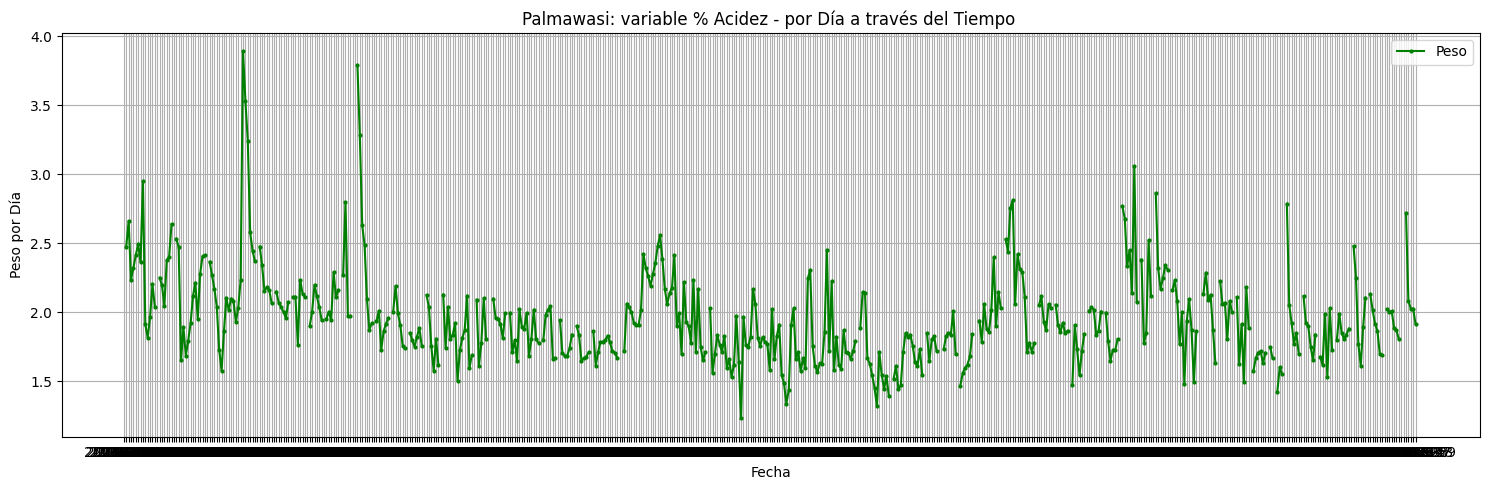

In [44]:
# function_tendencia_unica(df_acidez_full[df_acidez_full['PLANTACION'] == 'Shanuzi'], '% Acidez')
function_tendencia_unica(df_acidez_full[df_acidez_full['PLANTACION'] == 'Palmawasi'], '% Acidez')

In [45]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

# df_analisis_tendencia = df_acidez_full[df_acidez_full['PLANTACION'] == 'Shanuzi']
df_analisis_tendencia = df_acidez_full[df_acidez_full['PLANTACION'] == 'Palmawasi']

df_analisis_tendencia['FECHA'] = pd.to_datetime(df_analisis_tendencia['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia['SEMANA'] = df_analisis_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_analisis_tendencia.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_24184\3551390342.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia['FECHA'] = pd.to_datetime(df_analisis_tendencia['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_24184\3551390342.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia['SEMANA'] = df_analisis_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,% Acidez,SEMANA
2,2023-01-01,Palmawasi,NaN,2022-12-26
4,2023-01-02,Palmawasi,2.475000,2023-01-02
7,2023-01-03,Palmawasi,2.660000,2023-01-02
10,2023-01-04,Palmawasi,2.235000,2023-01-02
13,2023-01-05,Palmawasi,2.318333,2023-01-02


In [46]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_tendencia_semana = df_analisis_tendencia.groupby(['SEMANA','PLANTACION']).agg({'% Acidez': 'mean'}).reset_index()
df_analisis_tendencia_semana.columns = ['FECHA','PLANTACION','% Acidez']
df_analisis_tendencia_semana.head()

,FECHA,PLANTACION,% Acidez
0,2022-12-26,Palmawasi,NaN
1,2023-01-02,Palmawasi,2.421667
2,2023-01-09,Palmawasi,2.146111
3,2023-01-16,Palmawasi,2.316944
4,2023-01-23,Palmawasi,1.991190


Analisis de  2022-12-26 00:00:00  hasta  2024-06-24 00:00:00


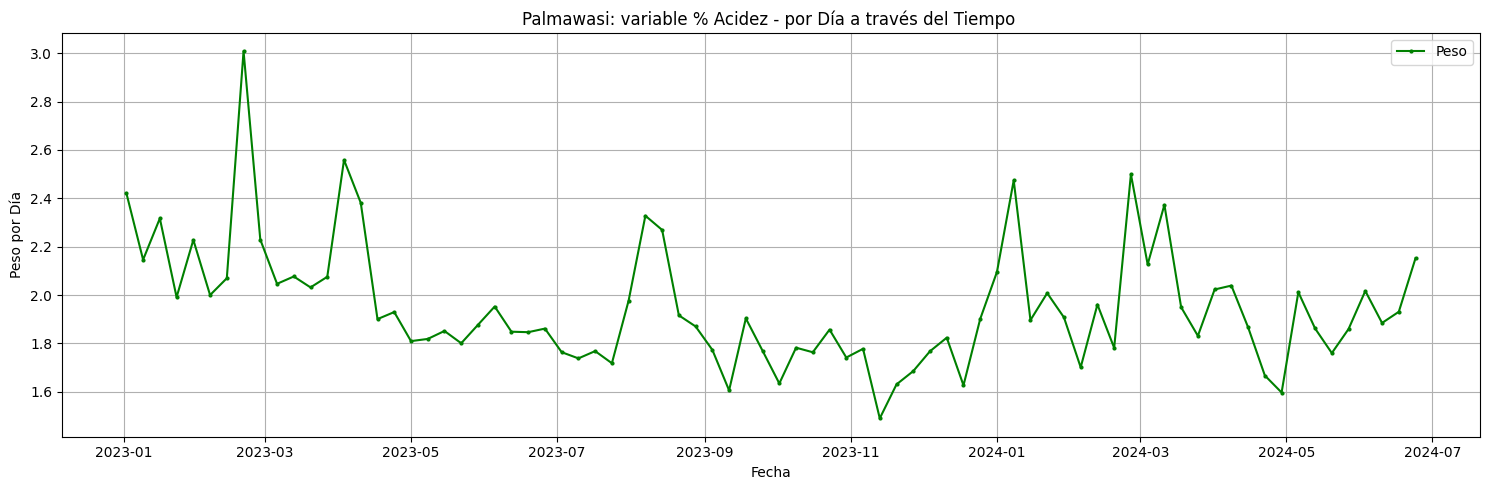

In [47]:
function_tendencia_unica(df_analisis_tendencia_semana, '% Acidez')

Calidad racimos propios

In [48]:
df_calidad_racimos_propios_full.head()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO
0,2021-08-18,Palmawasi,55.0,1978.0,62.0,0.0,0.0,45.0,5.0,NaN,NaN,2095.0,NaN,NaN,NaN,NaN
1,2021-08-19,Palmawasi,91.0,2100.0,91.0,0.0,0.0,89.0,9.0,NaN,NaN,2282.0,NaN,NaN,NaN,NaN
2,2021-08-20,Palmawasi,49.0,1776.0,78.0,9.0,0.0,52.0,6.0,NaN,NaN,1903.0,NaN,NaN,NaN,NaN
3,2021-08-21,Palmawasi,35.0,2033.0,113.0,0.0,0.0,62.0,4.0,NaN,NaN,2181.0,NaN,NaN,NaN,NaN
4,2021-08-23,Palmawasi,43.0,1288.0,121.0,0.0,0.0,41.0,3.0,NaN,NaN,1452.0,NaN,NaN,NaN,NaN


In [79]:
# df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi'].tail()
df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Palmawasi'].head()


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO
0,2021-08-18,Palmawasi,55.0,1978.0,62.0,0.0,0.0,45.0,5.0,NaN,NaN,2095.0,NaN,NaN,NaN,NaN
1,2021-08-19,Palmawasi,91.0,2100.0,91.0,0.0,0.0,89.0,9.0,NaN,NaN,2282.0,NaN,NaN,NaN,NaN
2,2021-08-20,Palmawasi,49.0,1776.0,78.0,9.0,0.0,52.0,6.0,NaN,NaN,1903.0,NaN,NaN,NaN,NaN
3,2021-08-21,Palmawasi,35.0,2033.0,113.0,0.0,0.0,62.0,4.0,NaN,NaN,2181.0,NaN,NaN,NaN,NaN
4,2021-08-23,Palmawasi,43.0,1288.0,121.0,0.0,0.0,41.0,3.0,NaN,NaN,1452.0,NaN,NaN,NaN,NaN


In [ ]:
#function_save(df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi'])

In [80]:
# Creando variables de calidad
df_calidad_racimos_propios_full['Peso_CALIDAD'] = df_calidad_racimos_propios_full[['VERDES','MADUROS','SMADUROS','ESCOBAJO']].sum(axis=1)

df_calidad_racimos_propios_full['Peso_VERDES'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['VERDES']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])
df_calidad_racimos_propios_full['Peso_MADUROS'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['MADUROS']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])
df_calidad_racimos_propios_full['Peso_SMADUROS'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['SMADUROS']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])
df_calidad_racimos_propios_full['Peso_ESCOBAJO'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['ESCOBAJO']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])

df_calidad_racimos_propios_full.head()


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO
0,2021-08-18,Palmawasi,55.0,1978.0,62.0,0.0,0.0,45.0,5.0,NaN,NaN,2095.0,NaN,NaN,NaN,NaN
1,2021-08-19,Palmawasi,91.0,2100.0,91.0,0.0,0.0,89.0,9.0,NaN,NaN,2282.0,NaN,NaN,NaN,NaN
2,2021-08-20,Palmawasi,49.0,1776.0,78.0,9.0,0.0,52.0,6.0,NaN,NaN,1903.0,NaN,NaN,NaN,NaN
3,2021-08-21,Palmawasi,35.0,2033.0,113.0,0.0,0.0,62.0,4.0,NaN,NaN,2181.0,NaN,NaN,NaN,NaN
4,2021-08-23,Palmawasi,43.0,1288.0,121.0,0.0,0.0,41.0,3.0,NaN,NaN,1452.0,NaN,NaN,NaN,NaN


In [81]:
df_calidad_racimos_propios_full['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_full['FECHA'])

In [82]:
df_calidad_racimos_propios_full.PLANTACION.unique()

array(['Palmawasi', 'Nuevo Horizonte', 'Shanuzi'], dtype=object)

In [83]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
# fecha_limite = pd.Timestamp('2023-03-16') ## --> Para sede Shanuzi
fecha_limite = pd.Timestamp('2023-01-01') ## --> Para sede Palmawasi 

# df_filtrado = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi'][df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi']['FECHA'] >= fecha_limite]
df_filtrado = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Palmawasi'][df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Palmawasi']['FECHA'] >= fecha_limite]


Analisis de  2023-01-02 00:00:00  hasta  2024-07-06 00:00:00


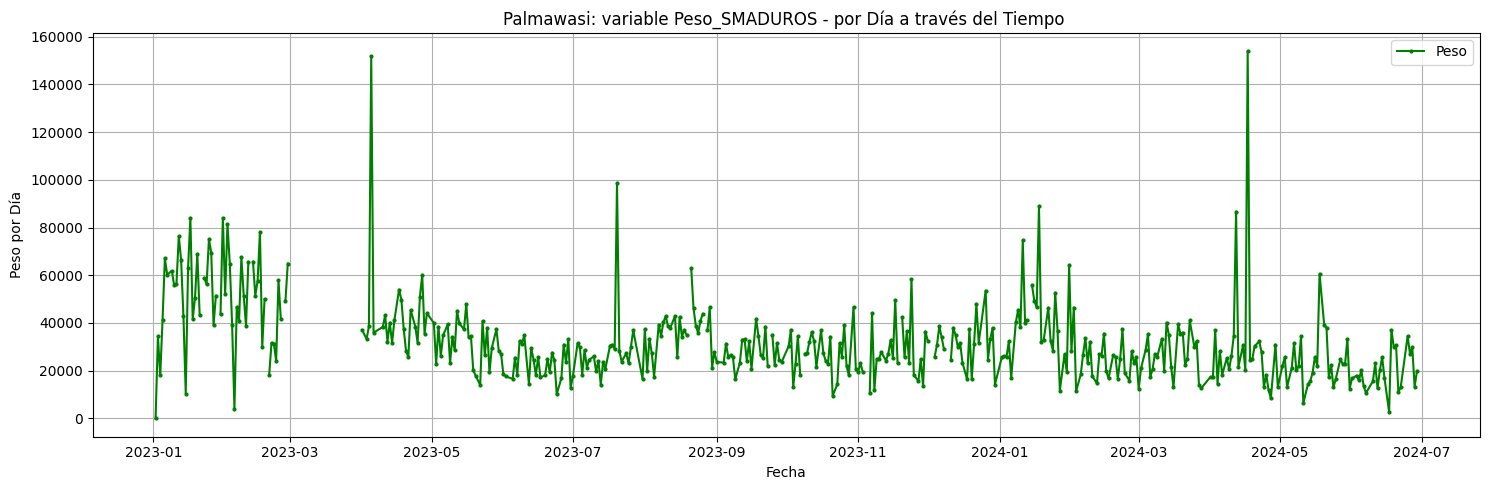

In [84]:
function_tendencia_unica(df_filtrado,'Peso_SMADUROS')

Analisis de  2022-12-26 00:00:00  hasta  2024-06-24 00:00:00


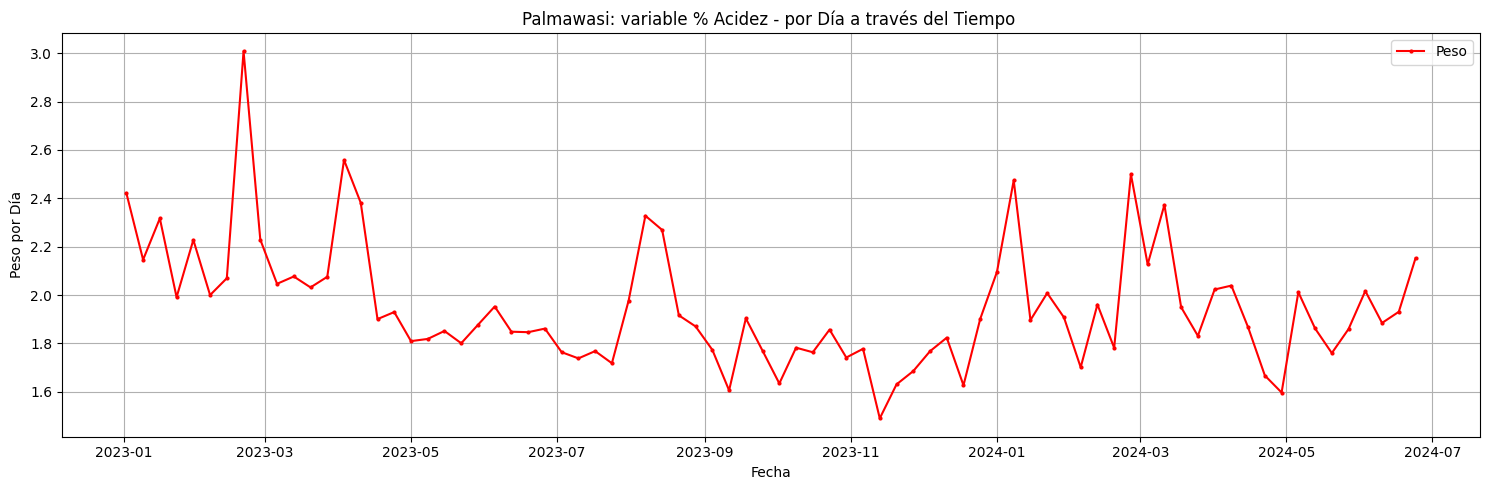

In [85]:
function_tendencia_unica(df_analisis_tendencia_semana, '% Acidez','red')

In [86]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

# df_analisis_tendencia_2 = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi']
df_analisis_tendencia_2 = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Palmawasi']

df_analisis_tendencia_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_2['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2['SEMANA'] = df_analisis_tendencia_2['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_analisis_tendencia_2.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_24184\1796893333.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_2['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_24184\1796893333.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_2['SEMANA'] = df_analisis_tendencia_2['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,SEMANA
0,2021-08-18,Palmawasi,55.0,1978.0,62.0,0.0,0.0,45.0,5.0,NaN,NaN,2095.0,NaN,NaN,NaN,NaN,2021-08-16
1,2021-08-19,Palmawasi,91.0,2100.0,91.0,0.0,0.0,89.0,9.0,NaN,NaN,2282.0,NaN,NaN,NaN,NaN,2021-08-16
2,2021-08-20,Palmawasi,49.0,1776.0,78.0,9.0,0.0,52.0,6.0,NaN,NaN,1903.0,NaN,NaN,NaN,NaN,2021-08-16
3,2021-08-21,Palmawasi,35.0,2033.0,113.0,0.0,0.0,62.0,4.0,NaN,NaN,2181.0,NaN,NaN,NaN,NaN,2021-08-16
4,2021-08-23,Palmawasi,43.0,1288.0,121.0,0.0,0.0,41.0,3.0,NaN,NaN,1452.0,NaN,NaN,NaN,NaN,2021-08-23


In [87]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_tendencia_semana_2 = df_analisis_tendencia_2.groupby(['SEMANA','PLANTACION']).agg({'Peso': 'sum',
                                                                                             'Racimos':'sum',
                                                                                             'Peso_CALIDAD':'sum',
                                                                                             'Peso_VERDES':'sum',
                                                                                             'Peso_MADUROS':'sum',
                                                                                             'Peso_SMADUROS':'sum',
                                                                                             'Peso_ESCOBAJO':'sum'}).reset_index()

df_analisis_tendencia_semana_2.columns = ['FECHA', 'PLANTACION', 'Peso', 'Racimos', 'Peso_CALIDAD','Peso_VERDES', 'Peso_MADUROS', 'Peso_SMADUROS', 'Peso_ESCOBAJO']
df_analisis_tendencia_semana_2.head()

,FECHA,PLANTACION,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO
0,2021-08-16,Palmawasi,0.0,0.0,8461.0,0.0,0.0,0.0,0.0
1,2021-08-23,Palmawasi,0.0,0.0,9450.0,0.0,0.0,0.0,0.0
2,2021-08-30,Palmawasi,0.0,0.0,13786.0,0.0,0.0,0.0,0.0
3,2021-09-06,Palmawasi,0.0,0.0,5775.0,0.0,0.0,0.0,0.0
4,2021-09-13,Palmawasi,0.0,0.0,9541.0,0.0,0.0,0.0,0.0


In [88]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
# fecha_limite = pd.Timestamp('2023-03-16') ## --> Para sede Shanuzi
fecha_limite = pd.Timestamp('2023-01-01') ## --> Para sede Palmawasi 

df_filtrado_2 = df_analisis_tendencia_semana_2[df_analisis_tendencia_semana_2['FECHA'] > fecha_limite]
df_filtrado_2.PLANTACION.unique()

array(['Palmawasi'], dtype=object)

Analisis de  2023-01-02 00:00:00  hasta  2024-07-01 00:00:00


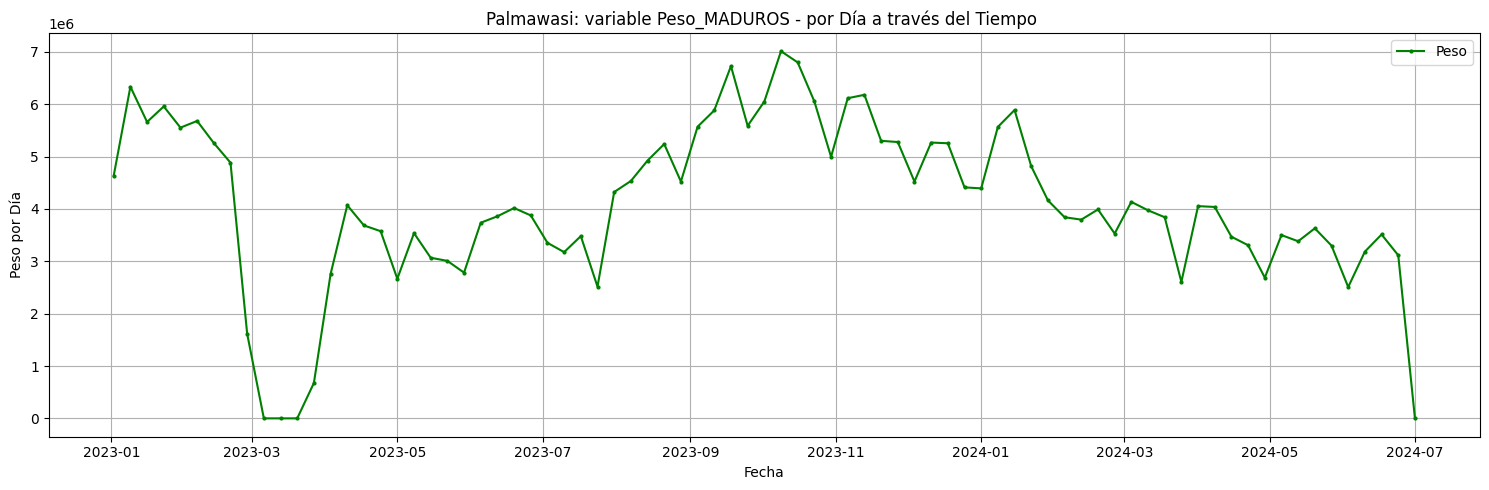

In [130]:
# function_tendencia_unica(df_filtrado_2,'Peso_VERDES')
function_tendencia_unica(df_filtrado_2,'Peso_MADUROS')
# function_tendencia_unica(df_filtrado_2,'Peso_SMADUROS')


In [90]:
# Filtrar el DataFrame para considerar solo las fechas mayores a ...
# fecha_limite = pd.Timestamp('2023-03-16') ## --> Para sede Shanuzi
fecha_limite = pd.Timestamp('2023-01-01') ## --> Para sede Palmawasi 

df_filtrado_3 = df_analisis_tendencia_semana[df_analisis_tendencia_semana['FECHA'] > fecha_limite]

Analisis de  2023-01-02 00:00:00  hasta  2024-06-24 00:00:00


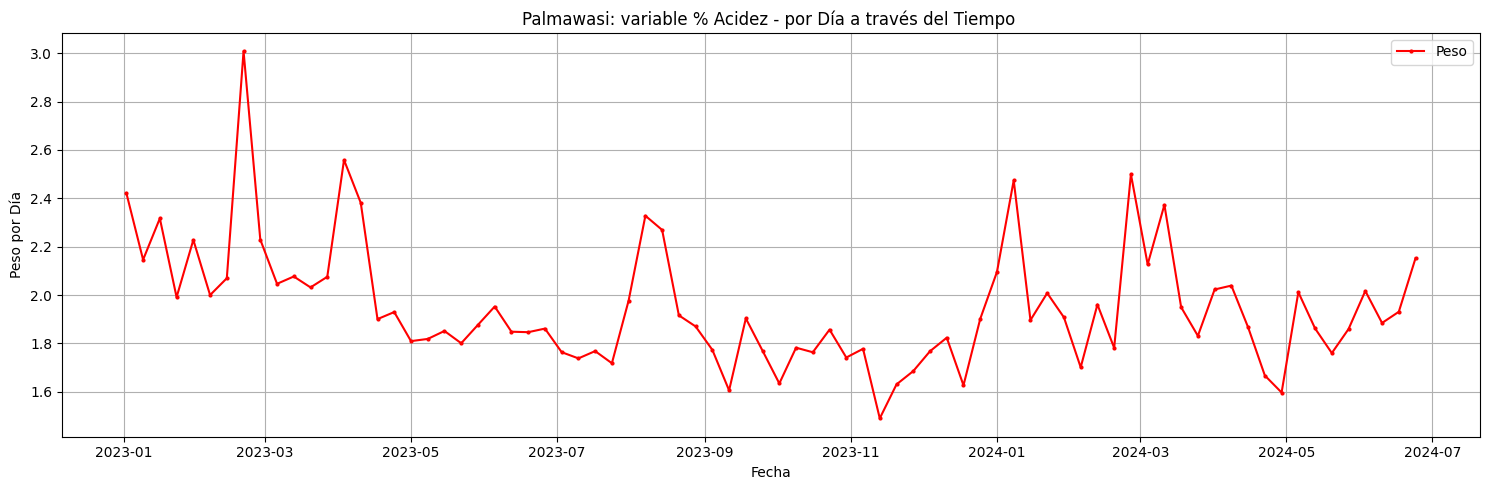

In [91]:
function_tendencia_unica(df_filtrado_3, '% Acidez','red')

In [92]:
#df_filtrado_3.head()
df_filtrado_2.head()


,FECHA,PLANTACION,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO
69,2023-01-02,Palmawasi,4.901528e+06,309787.0,28730.0,44274.530742,4.636227e+06,221025.580534,0.0
70,2023-01-09,Palmawasi,6.756267e+06,335472.0,36826.0,49839.202527,6.336043e+06,370384.782199,0.0
71,2023-01-16,Palmawasi,6.193259e+06,310777.0,31201.0,49259.006843,5.662606e+06,351637.370263,0.0
72,2023-01-23,Palmawasi,6.390178e+06,315540.0,26097.0,51786.924570,5.959241e+06,350104.136998,0.0
73,2023-01-30,Palmawasi,5.972128e+06,283399.0,30925.0,48479.954826,5.554185e+06,369462.915212,0.0


In [94]:
# AÑADIENDO DATOS DE BALANZA Y FABRICA
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_full = pd.merge(df_filtrado_3,
                            df_filtrado_2,
                            on=['FECHA', 'PLANTACION'], how='outer')
# Convertir 'FECHA' a formato datetime
df_analisis_full['FECHA'] = pd.to_datetime(df_analisis_full['FECHA'])
print(df_analisis_full.PLANTACION.unique())
df_analisis_full.head()

['Palmawasi']


,FECHA,PLANTACION,% Acidez,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO
0,2023-01-02,Palmawasi,2.421667,4.901528e+06,309787.0,28730.0,44274.530742,4.636227e+06,221025.580534,0.0
1,2023-01-09,Palmawasi,2.146111,6.756267e+06,335472.0,36826.0,49839.202527,6.336043e+06,370384.782199,0.0
2,2023-01-16,Palmawasi,2.316944,6.193259e+06,310777.0,31201.0,49259.006843,5.662606e+06,351637.370263,0.0
3,2023-01-23,Palmawasi,1.991190,6.390178e+06,315540.0,26097.0,51786.924570,5.959241e+06,350104.136998,0.0
4,2023-01-30,Palmawasi,2.228056,5.972128e+06,283399.0,30925.0,48479.954826,5.554185e+06,369462.915212,0.0


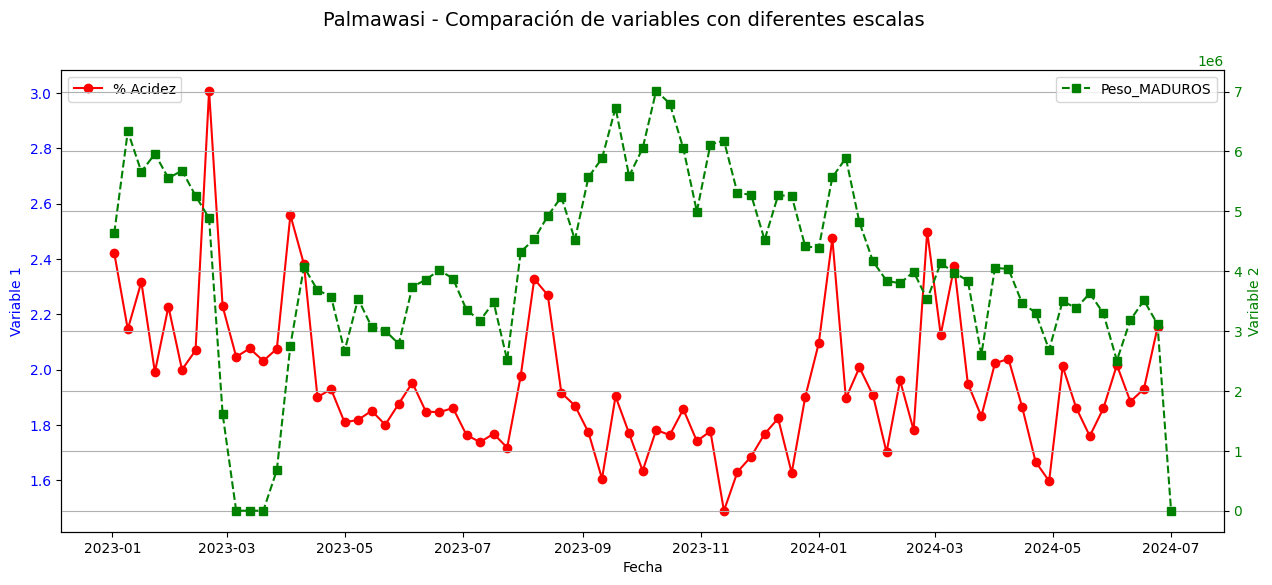

In [131]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['% Acidez'], color='red', marker='o', linestyle='-', label='% Acidez')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES'], color='green', marker='s', linestyle='--', label='Peso_VERDES')
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MADUROS'], color='green', marker='s', linestyle='--', label='Peso_MADUROS')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_SMADUROS'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de variables con diferentes escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [104]:
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_full['% Acidez_rolling_2'] = df_analisis_full['% Acidez'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['% Acidez_rolling_3'] = df_analisis_full['% Acidez'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['% Acidez_rolling_4'] = df_analisis_full['% Acidez'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['Peso_SMADUROS_rolling_2'] = df_analisis_full['Peso_SMADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_SMADUROS_rolling_3'] = df_analisis_full['Peso_SMADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_SMADUROS_rolling_4'] = df_analisis_full['Peso_SMADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['Peso_MADUROS_rolling_2'] = df_analisis_full['Peso_MADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_MADUROS_rolling_3'] = df_analisis_full['Peso_MADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_MADUROS_rolling_4'] = df_analisis_full['Peso_MADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos


df_analisis_full['Peso_VERDES_rolling_2'] = df_analisis_full['Peso_VERDES'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_VERDES_rolling_3'] = df_analisis_full['Peso_VERDES'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_VERDES_rolling_4'] = df_analisis_full['Peso_VERDES'].rolling(window=4).mean() # Suavizado a 4 periodos
df_analisis_full['Peso_VERDES_rolling_5'] = df_analisis_full['Peso_VERDES'].rolling(window=5).mean() # Suavizado a 4 periodos



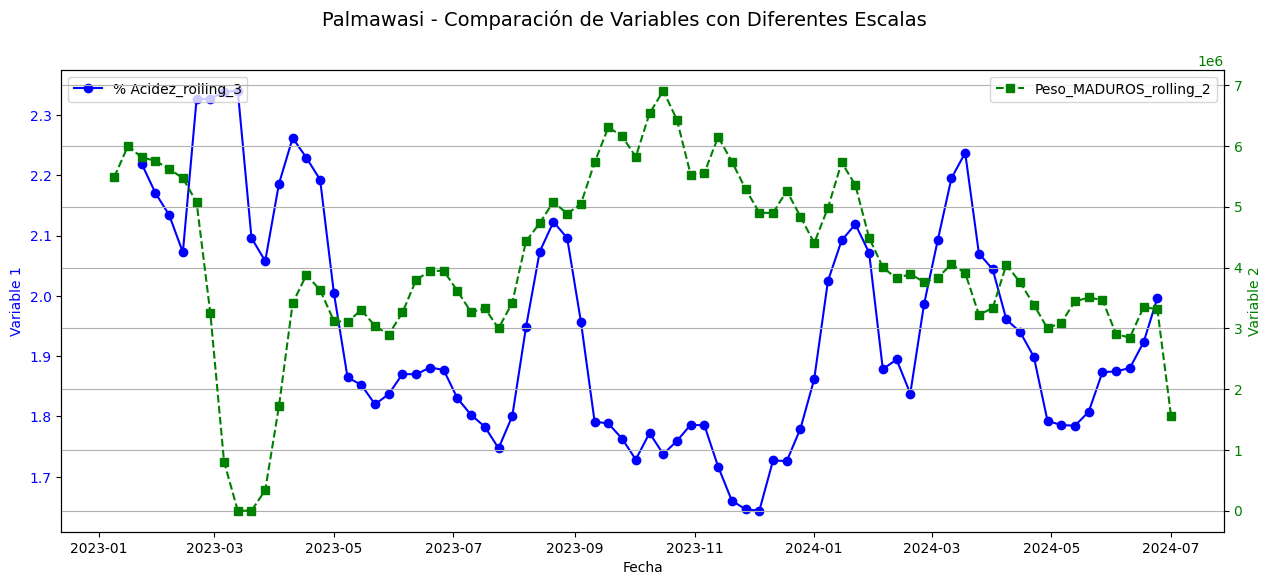

In [132]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
#ax1.plot(df_analisis_full['FECHA'], df_analisis_full['% Acidez'], color='blue', marker='o', linestyle='-', label='% Acidez')
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['% Acidez_rolling_4'], color='blue', marker='o', linestyle='-', label='% Acidez_rolling_3')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
#ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES'], color='green', marker='s', linestyle='--', label='Peso_VERDES')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES'], color='green', marker='s', linestyle='--', label='Peso_MADUROS')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_SMADUROS'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_SMADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS_rolling_2')

ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MADUROS_rolling_2')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_SMADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS_rolling_2')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_VERDES')


ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [149]:
df_analisis_full['% Acidez_rolling_2'].corr(df_analisis_full['Peso_SMADUROS_rolling_2'])

# df_analisis_full['% Acidez'].corr(df_analisis_full['Peso_MADUROS'])

# df_analisis_full['% Acidez'].corr(df_analisis_full['Peso_MADUROS'])
# df_analisis_full['% Acidez_rolling_3'].corr(df_analisis_full['Peso_VERDES'])



0.29383592459290164

In [146]:
def correlacion_cruzada(serie1, serie2):
    lags = np.arange(-len(serie1) + 1, len(serie1))
    corr = [serie1.corr(serie2.shift(lag)) for lag in lags]
    return lags, corr

lags, corr = correlacion_cruzada(df_analisis_full['% Acidez_rolling_2'], df_analisis_full['Peso_MADUROS_rolling_2'])
# lags, corr = correlacion_cruzada(df_analisis_full['% Acidez'], df_analisis_full['Peso_MADUROS'])
# lags, corr = correlacion_cruzada(df_analisis_full['% Acidez_rolling_3'], df_analisis_full['Peso_VERDES'])

In [147]:
lags, corr

(array([-78, -77, -76, -75, -74, -73, -72, -71, -70, -69, -68, -67, -66,
        -65, -64, -63, -62, -61, -60, -59, -58, -57, -56, -55, -54, -53,
        -52, -51, -50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40,
        -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27,
        -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14,
        -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,
          0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78]),
 [nan,
  nan,
  1.0,
  0.9228686666875143,
  0.5577679469485024,
  0.20055458162770015,
  0.6188693152533539,

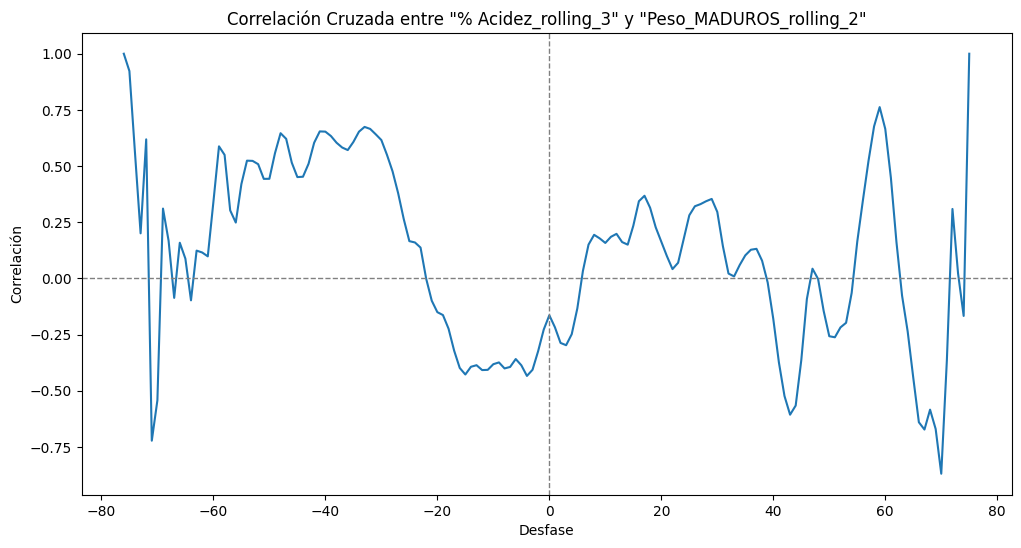

In [148]:
# Graficar correlación cruzada
plt.figure(figsize=(12, 6))
plt.plot(lags, corr)
plt.title('Correlación Cruzada entre "% Acidez_rolling_3" y "Peso_MADUROS_rolling_2"')
plt.xlabel('Desfase')
plt.ylabel('Correlación')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.show()

In [106]:
# Probando traslaciones temporales
# -----------

# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_full['% Acidez_SHIFTED_1'] = df_analisis_full['% Acidez'].shift(-1)
df_analisis_full['% Acidez_SHIFTED_2'] = df_analisis_full['% Acidez'].shift(-2)
df_analisis_full['% Acidez_SHIFTED_3'] = df_analisis_full['% Acidez'].shift(-3)
df_analisis_full['% Acidez_SHIFTED_4'] = df_analisis_full['% Acidez'].shift(-4)
df_analisis_full['% Acidez_SHIFTED_5'] = df_analisis_full['% Acidez'].shift(-5)
df_analisis_full['% Acidez_SHIFTED_6'] = df_analisis_full['% Acidez'].shift(-6)
df_analisis_full['% Acidez_SHIFTED_7'] = df_analisis_full['% Acidez'].shift(-7)

df_analisis_full.head()

,FECHA,PLANTACION,% Acidez,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,...,Peso_VERDES_rolling_3,Peso_VERDES_rolling_4,Peso_VERDES_rolling_5,% Acidez_SHIFTED_1,% Acidez_SHIFTED_2,% Acidez_SHIFTED_3,% Acidez_SHIFTED_4,% Acidez_SHIFTED_5,% Acidez_SHIFTED_6,% Acidez_SHIFTED_7
0,2023-01-02,Palmawasi,2.421667,4.901528e+06,309787.0,28730.0,44274.530742,4.636227e+06,221025.580534,0.0,...,NaN,NaN,NaN,2.146111,2.316944,1.991190,2.228056,2.000000,2.069571,3.008194
1,2023-01-09,Palmawasi,2.146111,6.756267e+06,335472.0,36826.0,49839.202527,6.336043e+06,370384.782199,0.0,...,NaN,NaN,NaN,2.316944,1.991190,2.228056,2.000000,2.069571,3.008194,2.229167
2,2023-01-16,Palmawasi,2.316944,6.193259e+06,310777.0,31201.0,49259.006843,5.662606e+06,351637.370263,0.0,...,47790.913370,NaN,NaN,1.991190,2.228056,2.000000,2.069571,3.008194,2.229167,2.046500
3,2023-01-23,Palmawasi,1.991190,6.390178e+06,315540.0,26097.0,51786.924570,5.959241e+06,350104.136998,0.0,...,50295.044647,48789.916170,NaN,2.228056,2.000000,2.069571,3.008194,2.229167,2.046500,2.076806
4,2023-01-30,Palmawasi,2.228056,5.972128e+06,283399.0,30925.0,48479.954826,5.554185e+06,369462.915212,0.0,...,49841.962080,49841.272191,48727.923901,2.000000,2.069571,3.008194,2.229167,2.046500,2.076806,2.031667


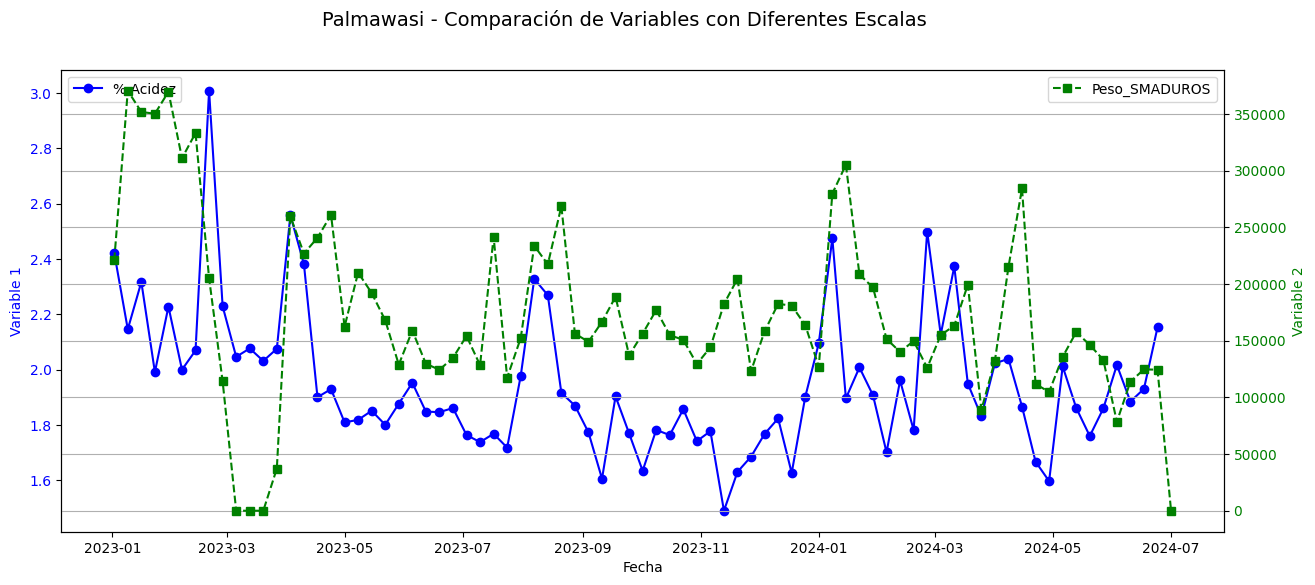

In [118]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['% Acidez'], color='blue', marker='o', linestyle='-', label='% Acidez')
#ax1.plot(df_analisis_full['FECHA'], df_analisis_full['% Acidez_SHIFTED_5'], color='red', marker='o', linestyle='-', label='% Acidez_SHIFTED_5')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES'], color='green', marker='s', linestyle='--', label='Peso_VERDES')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MADUROS'], color='green', marker='s', linestyle='--', label='Peso_MADUROS')
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_SMADUROS'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [117]:
df_analisis_full['% Acidez_SHIFTED_5'].corr(df_analisis_full['Peso_SMADUROS'])

0.14118434071858157

In [ ]:
# Datos de ejemplo
toneladas = np.array([100, 200, 300, 400, 500])
porcentajes = np.array([10, 20, 30, 40, 50])

In [ ]:
# Normalización (escalado)
toneladas_norm = (df_analisis_full['Peso_VERDES'] - np.mean(df_analisis_full['Peso_VERDES'])) / np.std(df_analisis_full['Peso_VERDES'])
porcentajes_norm = (df_analisis_full['% Acidez'] - np.mean(df_analisis_full['% Acidez'])) / np.std(df_analisis_full['% Acidez'])

In [ ]:
# Calcular la correlación de Pearson
correlacion, _ = pearsonr(toneladas_norm, porcentajes_norm)
print(f'Correlación de Pearson: {correlacion}')

In [ ]:
# Calcular la correlación de Pearson
correlacion, _ = pearsonr(toneladas, porcentajes)
print(f'Correlación de Pearson: {correlacion}')

##### PROPORCION DE PARTICIPACION PROPIOS Y TERCEROS

In [ ]:
df_participacion_cashcost_full.head()

In [ ]:
df_participacion_cashcost_full.groupby('PLANTACION').size()

In [ ]:
df_analisis_participacion = df_participacion_cashcost_full[df_participacion_cashcost_full['PLANTACION'] == 'Shanuzi']
df_analisis_participacion.tail()

In [ ]:
function_tendencia_unica(df_analisis_participacion,'RFFProcesado')

In [ ]:
df_analisis_participacion.columns

In [ ]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_participacion['FECHA'] = pd.to_datetime(df_analisis_participacion['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_participacion['SEMANA'] = df_analisis_participacion['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_analisis_participacion['MES'] = df_analisis_participacion['FECHA'].dt.to_period('M').apply(lambda r: r.start_time)

# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_participacion_semana = df_analisis_participacion.groupby(['SEMANA','PLANTACION']).agg({'RFFProcesado': 'sum',
                                                                                                   'RFFProcesadoPropios':'sum',
                                                                                                   'RFFProcesadoTerceros':'sum',
                                                                                                   'CPOObtenido':'sum',
                                                                                                   'CPOObtenidoPropios':'sum',
                                                                                                   'CPOObtenidoTerceros':'sum'}).reset_index()
df_analisis_participacion_semana.columns = ['FECHA', 'PLANTACION', 'RFFProcesado', 'RFFProcesadoPropios','RFFProcesadoTerceros', 'CPOObtenido', 'CPOObtenidoPropios','CPOObtenidoTerceros']

# Agrupar por 'MES' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_participacion_mes = df_analisis_participacion.groupby(['MES','PLANTACION']).agg({'RFFProcesado': 'sum',
                                                                                             'RFFProcesadoPropios':'sum',
                                                                                             'RFFProcesadoTerceros':'sum',
                                                                                             'CPOObtenido':'sum',
                                                                                             'CPOObtenidoPropios':'sum',
                                                                                             'CPOObtenidoTerceros':'sum'}).reset_index()
df_analisis_participacion_mes.columns = ['FECHA', 'PLANTACION', 'RFFProcesado', 'RFFProcesadoPropios','RFFProcesadoTerceros', 'CPOObtenido', 'CPOObtenidoPropios',
       'CPOObtenidoTerceros']

df_analisis_participacion_mes.head()

In [ ]:
function_tendencia_unica(df_analisis_participacion_semana,'RFFProcesado')

In [ ]:
# Mostrando el % de participacion
# ---
df_analisis_participacion_mes['Propios_Porcentaje'] = df_analisis_participacion_mes['RFFProcesadoPropios'] / df_analisis_participacion_semana['RFFProcesado'] * 100
df_analisis_participacion_mes['Terceros_Porcentaje'] = df_analisis_participacion_mes['RFFProcesadoTerceros'] / df_analisis_participacion_semana['RFFProcesado'] * 100
df_analisis_participacion_mes.head()

In [ ]:
df_analisis_participacion_mes['Fecha_cat'] = df_analisis_participacion_mes['FECHA'].astype('object')
df_analisis_participacion_mes.head()

In [ ]:
function_save(df_analisis_participacion_mes)

In [ ]:
# Configuración del gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Ajuste del ancho de las barras
# Graficar barras apiladas
ax.bar(df_analisis_participacion_mes['Fecha_cat'], df_analisis_participacion_mes['Propios_Porcentaje'],  label='Propios')
ax.bar(df_analisis_participacion_mes['Fecha_cat'], df_analisis_participacion_mes['Terceros_Porcentaje'], bottom=df_analisis_participacion_mes['Propios_Porcentaje'], label='Terceros')

# Etiquetas y título
ax.set_xlabel('Fecha')
ax.set_ylabel('Porcentaje de Participación')
ax.set_title('Participación de RFF Procesado a través del tiempo')
ax.legend()

# Mostrar gráfico
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

##### DATOS PRECIPITACION

In [213]:
print(df_calidad_precipitacion_full.PLANTACION.unique())

print(f'Precipitacion máxima: {df_calidad_precipitacion_full.PRECIPITACION_TOTAL.max()}')
print(f'Precipitacion mínima: {df_calidad_precipitacion_full.PRECIPITACION_TOTAL.min()}')
print(f'Precipitacion promedio: {df_calidad_precipitacion_full.PRECIPITACION_TOTAL.mean()}')

df_calidad_precipitacion_full.head()


['Nuevo Horizonte' 'Palmawasi' 'Shanuzi' 'Tulumayo']
Precipitacion máxima: 1919.33
Precipitacion mínima: 0.0
Precipitacion promedio: 38.41761521778421


,FECHA,PLANTACION,PRECIPITACION_TOTAL
0,2019-01-01,Nuevo Horizonte,0.0
1,2019-01-01,Palmawasi,0.0
2,2019-01-02,Nuevo Horizonte,0.0
3,2019-01-02,Palmawasi,0.0
4,2019-01-03,Nuevo Horizonte,0.0


Analisis de  2019-01-01 00:00:00  hasta  2024-03-17 00:00:00


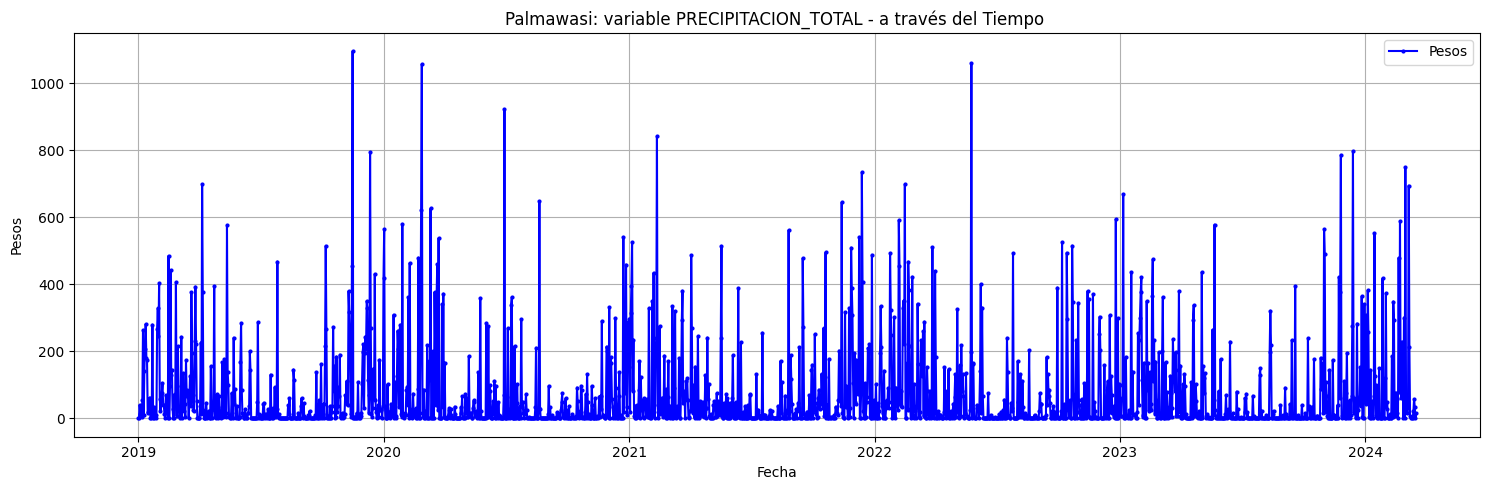

In [214]:
function_tendencia_unica(df_calidad_precipitacion_full[df_calidad_precipitacion_full['PLANTACION'] == 'Palmawasi'], 'PRECIPITACION_TOTAL','blue')
# function_tendencia_unica(df_calidad_precipitacion_full[df_calidad_precipitacion_full['PLANTACION'] == 'Shanuzi'], 'PRECIPITACION_TOTAL','blue)

In [215]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_tendencia = df_calidad_precipitacion_full[df_calidad_precipitacion_full['PLANTACION'] == 'Palmawasi']
# df_analisis_tendencia = df_calidad_precipitacion_full[df_calidad_precipitacion_full['PLANTACION'] == 'Shanuzi']


df_analisis_tendencia['FECHA'] = pd.to_datetime(df_analisis_tendencia['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia['SEMANA'] = df_analisis_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_analisis_tendencia.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_20696\3517276731.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia['FECHA'] = pd.to_datetime(df_analisis_tendencia['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_20696\3517276731.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia['SEMANA'] = df_analisis_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,PRECIPITACION_TOTAL,SEMANA
1,2019-01-01,Palmawasi,0.0,2018-12-31
3,2019-01-02,Palmawasi,0.0,2018-12-31
5,2019-01-03,Palmawasi,40.3,2018-12-31
7,2019-01-04,Palmawasi,12.5,2018-12-31
9,2019-01-05,Palmawasi,14.9,2018-12-31


In [216]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_tendencia_semana = df_analisis_tendencia.groupby(['SEMANA','PLANTACION']).agg({'PRECIPITACION_TOTAL': 'sum'}).reset_index()
df_analisis_tendencia_semana.columns = ['FECHA','PLANTACION','PRECIPITACION_TOTAL']
df_analisis_tendencia_semana.head()

,FECHA,PLANTACION,PRECIPITACION_TOTAL
0,2018-12-31,Palmawasi,72.1
1,2019-01-07,Palmawasi,1139.6
2,2019-01-14,Palmawasi,320.3
3,2019-01-21,Palmawasi,335.3
4,2019-01-28,Palmawasi,1321.6


Analisis de  2018-12-31 00:00:00  hasta  2024-03-11 00:00:00


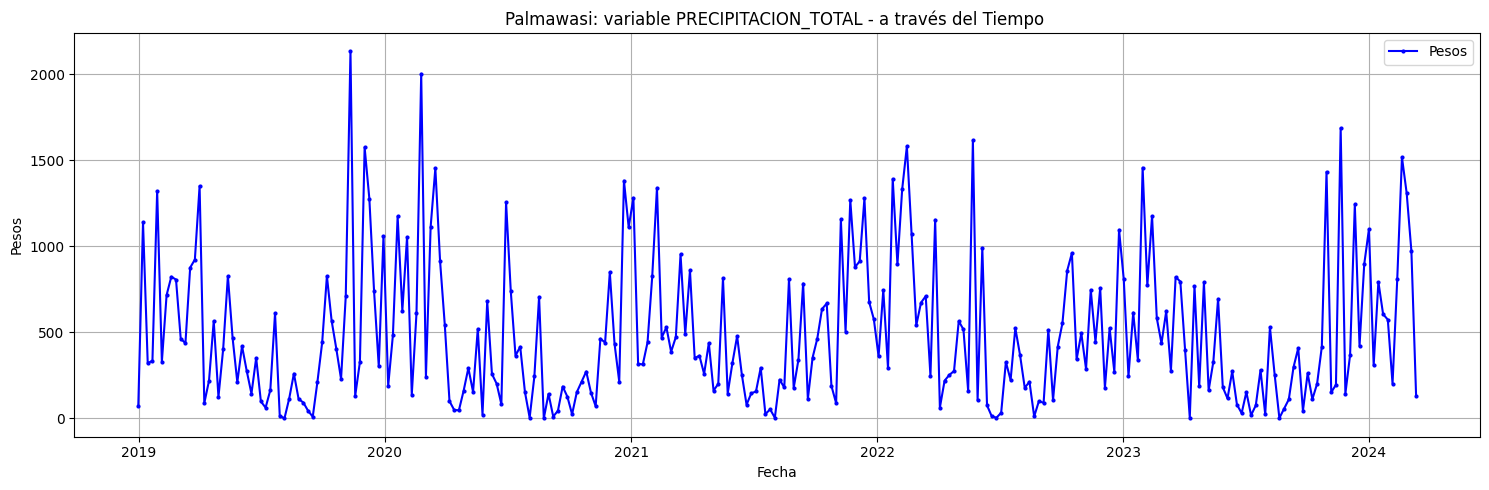

In [217]:
function_tendencia_unica(df_analisis_tendencia_semana, 'PRECIPITACION_TOTAL','blue')

In [218]:
df_filtrado_3 = df_analisis_tendencia_semana

Calidad racimos propios

In [219]:
df_calidad_racimos_propios_full.head()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MAFORMADOA,Peso_MAFORMADOB
0,2021-08-18,Palmawasi,55.0,1978.0,62.0,0.0,0.0,45.0,5.0,NaN,NaN,2095.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-19,Palmawasi,91.0,2100.0,91.0,0.0,0.0,89.0,9.0,NaN,NaN,2282.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-08-20,Palmawasi,49.0,1776.0,78.0,9.0,0.0,52.0,6.0,NaN,NaN,1903.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-08-21,Palmawasi,35.0,2033.0,113.0,0.0,0.0,62.0,4.0,NaN,NaN,2181.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-08-23,Palmawasi,43.0,1288.0,121.0,0.0,0.0,41.0,3.0,NaN,NaN,1452.0,NaN,NaN,NaN,NaN,NaN,NaN


In [220]:
# Creando variables de calidad
df_calidad_racimos_propios_full['Peso_CALIDAD'] = df_calidad_racimos_propios_full[['VERDES','MADUROS','SMADUROS','ESCOBAJO']].sum(axis=1)

df_calidad_racimos_propios_full['Peso_VERDES'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['VERDES']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])
df_calidad_racimos_propios_full['Peso_MADUROS'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['MADUROS']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])
df_calidad_racimos_propios_full['Peso_SMADUROS'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['SMADUROS']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])
df_calidad_racimos_propios_full['Peso_ESCOBAJO'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['ESCOBAJO']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])

df_calidad_racimos_propios_full['Peso_MAFORMADOA'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['MALFORMADOA']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])
df_calidad_racimos_propios_full['Peso_MAFORMADOB'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['MALFORMADOB']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])

df_calidad_racimos_propios_full.head()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MAFORMADOA,Peso_MAFORMADOB
0,2021-08-18,Palmawasi,55.0,1978.0,62.0,0.0,0.0,45.0,5.0,NaN,NaN,2095.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-19,Palmawasi,91.0,2100.0,91.0,0.0,0.0,89.0,9.0,NaN,NaN,2282.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-08-20,Palmawasi,49.0,1776.0,78.0,9.0,0.0,52.0,6.0,NaN,NaN,1903.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-08-21,Palmawasi,35.0,2033.0,113.0,0.0,0.0,62.0,4.0,NaN,NaN,2181.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-08-23,Palmawasi,43.0,1288.0,121.0,0.0,0.0,41.0,3.0,NaN,NaN,1452.0,NaN,NaN,NaN,NaN,NaN,NaN


In [221]:
df_calidad_racimos_propios_full['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_full['FECHA'])

In [222]:
df_calidad_racimos_propios_full.PLANTACION.unique()

array(['Palmawasi', 'Nuevo Horizonte', 'Shanuzi'], dtype=object)

In [223]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
fecha_limite = pd.Timestamp('2022-01-01') ## --> Para sede Palmawasi
# fecha_limite = pd.Timestamp('2023-03-01') ## --> Para sede Shanuzi

df_filtrado = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Palmawasi'][df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Palmawasi']['FECHA'] >= fecha_limite]
# df_filtrado = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi'][df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi']['FECHA'] >= fecha_limite]

In [166]:
# function_completitud_pen(df_calidad_racimos_propios_full,'Peso_MAFORMADOA',1)

Timestamp('2021-08-18 00:00:00')

Analisis de  2022-01-03 00:00:00  hasta  2024-07-06 00:00:00


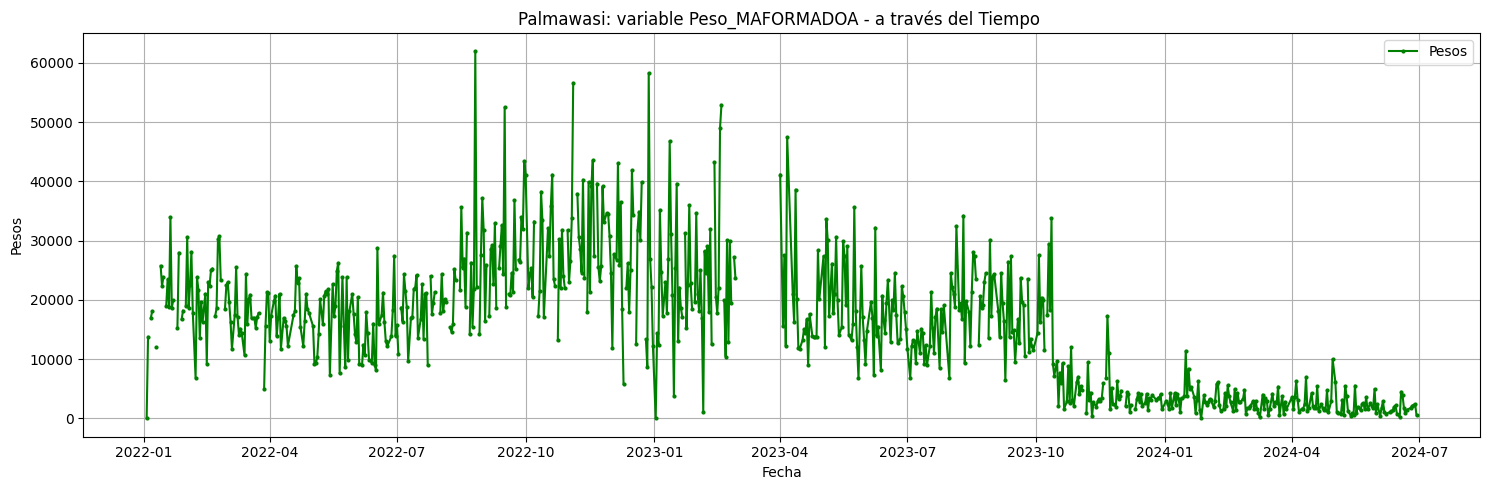

In [224]:
function_tendencia_unica(df_filtrado,'Peso_MAFORMADOA','green')

In [225]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_tendencia_2 = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Palmawasi']
# df_analisis_tendencia_2 = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi']

df_analisis_tendencia_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_2['FECHA'])


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_20696\754189614.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_2['FECHA'])


In [226]:
# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2['SEMANA'] = df_analisis_tendencia_2['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_analisis_tendencia_2.head()


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_20696\1360649808.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_2['SEMANA'] = df_analisis_tendencia_2['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MAFORMADOA,Peso_MAFORMADOB,SEMANA
0,2021-08-18,Palmawasi,55.0,1978.0,62.0,0.0,0.0,45.0,5.0,NaN,NaN,2095.0,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-16
1,2021-08-19,Palmawasi,91.0,2100.0,91.0,0.0,0.0,89.0,9.0,NaN,NaN,2282.0,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-16
2,2021-08-20,Palmawasi,49.0,1776.0,78.0,9.0,0.0,52.0,6.0,NaN,NaN,1903.0,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-16
3,2021-08-21,Palmawasi,35.0,2033.0,113.0,0.0,0.0,62.0,4.0,NaN,NaN,2181.0,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-16
4,2021-08-23,Palmawasi,43.0,1288.0,121.0,0.0,0.0,41.0,3.0,NaN,NaN,1452.0,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-23


In [227]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_tendencia_semana_2 = df_analisis_tendencia_2.groupby(['SEMANA','PLANTACION']).agg({'Peso': 'sum',
                                                                                             'Racimos':'sum',
                                                                                             'Peso_CALIDAD':'sum',
                                                                                             'Peso_VERDES':'sum',
                                                                                             'Peso_MADUROS':'sum',
                                                                                             'Peso_SMADUROS':'sum',
                                                                                             'Peso_ESCOBAJO':'sum',
                                                                                             'Peso_MAFORMADOA':'sum',
                                                                                             'Peso_MAFORMADOB':'sum'}).reset_index()

df_analisis_tendencia_semana_2.columns = ['FECHA', 'PLANTACION', 'Peso', 'Racimos', 'Peso_CALIDAD','Peso_VERDES', 'Peso_MADUROS', 'Peso_SMADUROS', 'Peso_ESCOBAJO','Peso_MAFORMADOA','Peso_MAFORMADOB']
df_analisis_tendencia_semana_2.head()

,FECHA,PLANTACION,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MAFORMADOA,Peso_MAFORMADOB
0,2021-08-16,Palmawasi,0.0,0.0,8461.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-08-23,Palmawasi,0.0,0.0,9450.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-08-30,Palmawasi,0.0,0.0,13786.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-09-06,Palmawasi,0.0,0.0,5775.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-09-13,Palmawasi,0.0,0.0,9541.0,0.0,0.0,0.0,0.0,0.0,0.0


In [228]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
fecha_limite = pd.Timestamp('2022-01-01') ## --> Para sede Palmawasi 
# fecha_limite = pd.Timestamp('2023-03-01') ## --> Para sede Shanuzi 

df_filtrado_2 = df_analisis_tendencia_semana_2[df_analisis_tendencia_semana_2['FECHA'] > fecha_limite]
df_filtrado_2.PLANTACION.unique()

array(['Palmawasi'], dtype=object)

Analisis de  2022-01-03 00:00:00  hasta  2024-07-01 00:00:00


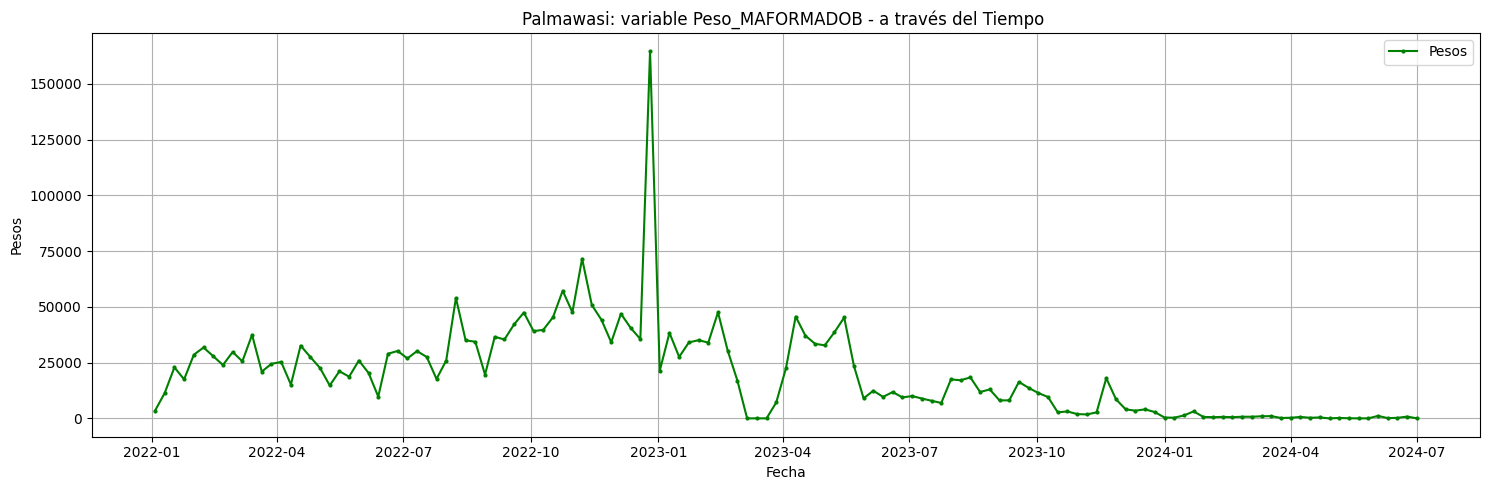

In [234]:
#function_tendencia_unica(df_analisis_tendencia_semana_2,'Peso_MAFORMADOA','green')
# function_tendencia_unica(df_filtrado_2,'Peso_MAFORMADOA','green')
function_tendencia_unica(df_filtrado_2,'Peso_MAFORMADOB','green')


In [235]:
print(df_filtrado_3.PLANTACION.unique())
df_filtrado_3.head()

['Palmawasi']


,FECHA,PLANTACION,PRECIPITACION_TOTAL
0,2018-12-31,Palmawasi,72.1
1,2019-01-07,Palmawasi,1139.6
2,2019-01-14,Palmawasi,320.3
3,2019-01-21,Palmawasi,335.3
4,2019-01-28,Palmawasi,1321.6


In [208]:
fecha_limite = pd.Timestamp('2019-03-01') ## --> Para sede Shanuzi

df_filtrado_3_1 = df_filtrado_3[df_filtrado_3['FECHA'] >= fecha_limite]
df_filtrado_3_1.head()

,FECHA,PLANTACION,PRECIPITACION_TOTAL
657,2019-03-04,Shanuzi,860.7
658,2019-03-11,Shanuzi,376.8
659,2019-03-18,Shanuzi,466.7
660,2019-03-25,Shanuzi,654.2
661,2019-04-01,Shanuzi,677.2


Analisis de  2018-12-31 00:00:00  hasta  2024-03-11 00:00:00


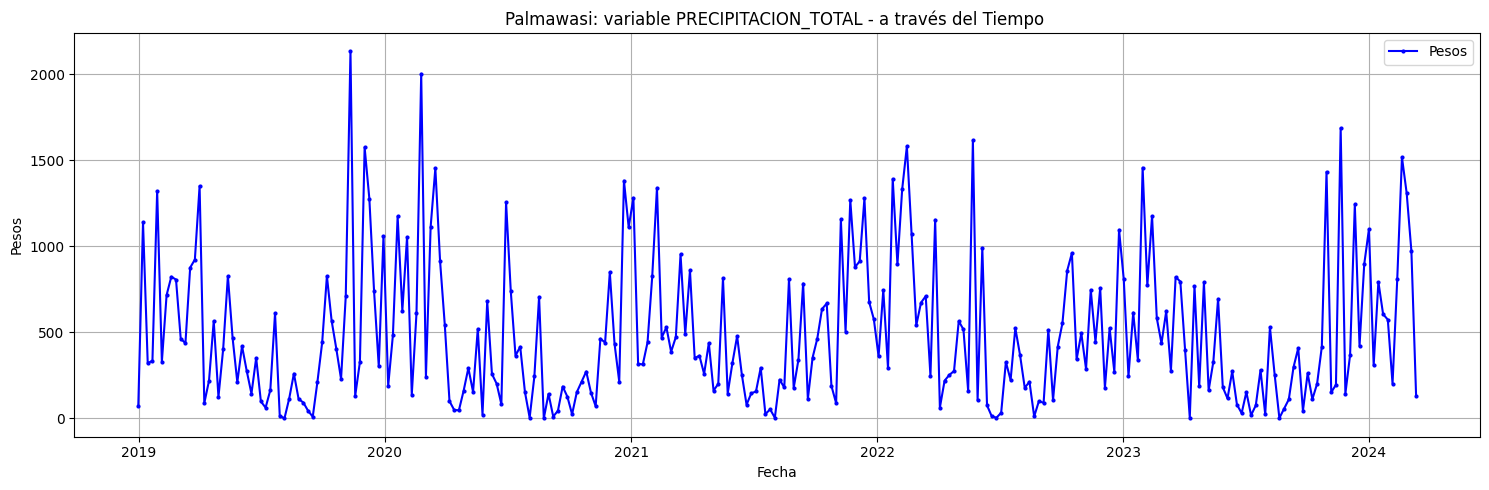

In [231]:
function_tendencia_unica(df_filtrado_3, 'PRECIPITACION_TOTAL','blue')
# function_tendencia_unica(df_filtrado_3_1, 'PRECIPITACION_TOTAL','blue') # shanuzi

In [131]:
df_filtrado_3_1.head()

,FECHA,PLANTACION,PRECIPITACION_TOTAL
657,2019-03-04,Shanuzi,860.7
658,2019-03-11,Shanuzi,376.8
659,2019-03-18,Shanuzi,466.7
660,2019-03-25,Shanuzi,654.2
661,2019-04-01,Shanuzi,677.2


In [236]:
# AÑADIENDO DATOS DE BALANZA Y FABRICA
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_full = pd.merge(df_filtrado_3,
                            df_filtrado_2,
                            on=['FECHA', 'PLANTACION'], how='outer')
# Convertir 'FECHA' a formato datetime
df_analisis_full['FECHA'] = pd.to_datetime(df_analisis_full['FECHA'])
print(df_analisis_full.PLANTACION.unique())
df_analisis_full.head()

['Palmawasi']


,FECHA,PLANTACION,PRECIPITACION_TOTAL,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MAFORMADOA,Peso_MAFORMADOB
0,2018-12-31,Palmawasi,72.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-07,Palmawasi,1139.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-14,Palmawasi,320.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-21,Palmawasi,335.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-28,Palmawasi,1321.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


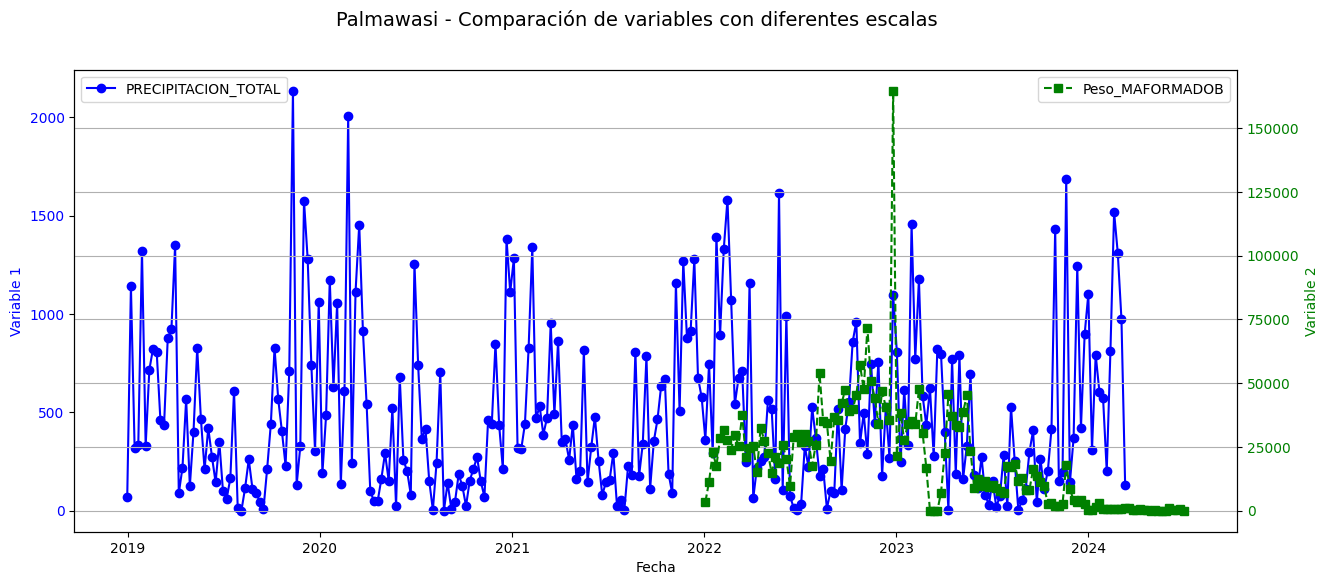

In [238]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['PRECIPITACION_TOTAL'], color='blue', marker='o', linestyle='-', label='PRECIPITACION_TOTAL')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MAFORMADOA'], color='green', marker='s', linestyle='--', label='Peso_MAFORMADOA')
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MAFORMADOB'], color='green', marker='s', linestyle='--', label='Peso_MAFORMADOB')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de variables con diferentes escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()



In [121]:
df_analisis_full.columns

Index(['FECHA', 'PLANTACION', 'PRECIPITACION_TOTAL', 'Peso', 'Racimos',
       'Peso_CALIDAD', 'Peso_VERDES', 'Peso_MADUROS', 'Peso_SMADUROS',
       'Peso_ESCOBAJO', 'Peso_MAFORMADOA', 'Peso_MAFORMADOB'],
      dtype='object')

In [161]:

# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_full['PRECIPITACION_TOTAL_rolling_2'] = df_analisis_full['PRECIPITACION_TOTAL'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['PRECIPITACION_TOTAL_rolling_3'] = df_analisis_full['PRECIPITACION_TOTAL'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['PRECIPITACION_TOTAL_rolling_4'] = df_analisis_full['PRECIPITACION_TOTAL'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['Peso_VERDES_rolling_2'] = df_analisis_full['Peso_VERDES'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_VERDES_rolling_3'] = df_analisis_full['Peso_VERDES'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_VERDES_rolling_4'] = df_analisis_full['Peso_VERDES'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['Peso_MADUROS_rolling_2'] = df_analisis_full['Peso_MADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_MADUROS_rolling_3'] = df_analisis_full['Peso_MADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_MADUROS_rolling_4'] = df_analisis_full['Peso_MADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['Peso_SMADUROS_rolling_2'] = df_analisis_full['Peso_SMADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_SMADUROS_rolling_3'] = df_analisis_full['Peso_SMADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_SMADUROS_rolling_4'] = df_analisis_full['Peso_SMADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos

# --
df_analisis_full['Peso_MAFORMADOA_rolling_2'] = df_analisis_full['Peso_MAFORMADOA'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_MAFORMADOA_rolling_3'] = df_analisis_full['Peso_MAFORMADOA'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_MAFORMADOA_rolling_4'] = df_analisis_full['Peso_MAFORMADOA'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['Peso_MAFORMADOB_rolling_2'] = df_analisis_full['Peso_MAFORMADOB'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_MAFORMADOB_rolling_3'] = df_analisis_full['Peso_MAFORMADOB'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_MAFORMADOB_rolling_4'] = df_analisis_full['Peso_MAFORMADOB'].rolling(window=4).mean() # Suavizado a 4 periodos


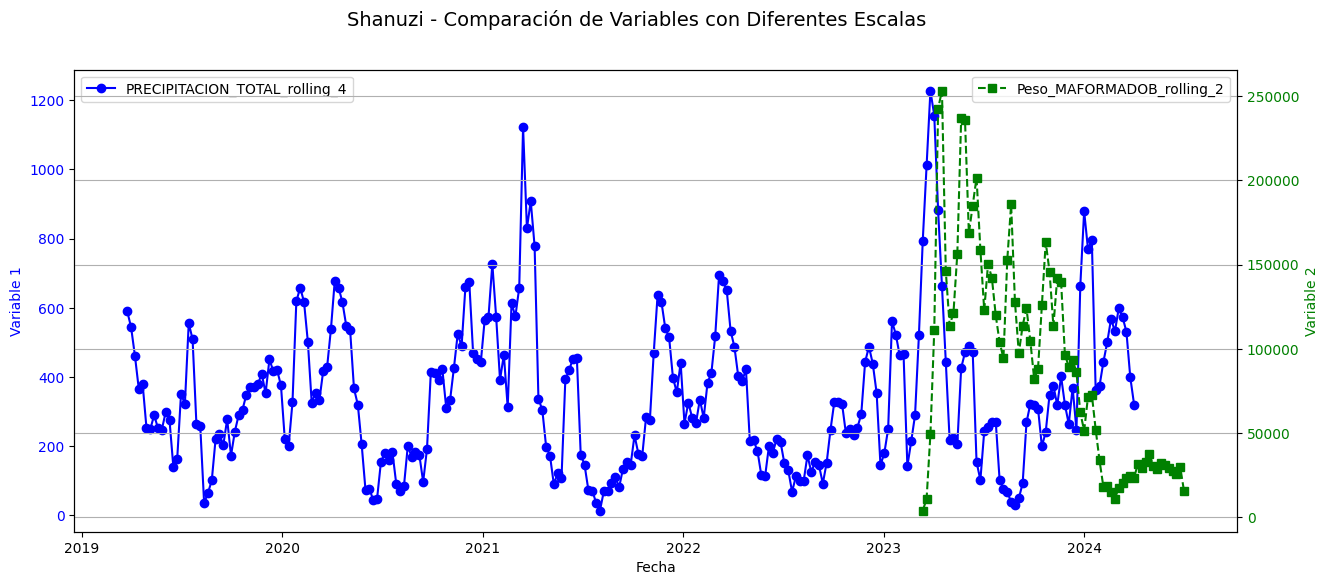

In [162]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
#ax1.plot(df_analisis_full['FECHA'], df_analisis_full['% Acidez'], color='blue', marker='o', linestyle='-', label='% Acidez')
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['PRECIPITACION_TOTAL_rolling_4'], color='blue', marker='o', linestyle='-', label='PRECIPITACION_TOTAL_rolling_4')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MADUROS_rolling_2')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MAFORMADOA_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MAFORMADOA_rolling_2')
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MAFORMADOB_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MAFORMADOB_rolling_2')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()



In [101]:
df_analisis_full.columns

Index(['FECHA', 'PLANTACION', 'PRECIPITACION_TOTAL', 'Peso', 'Racimos',
       'Peso_CALIDAD', 'Peso_VERDES', 'Peso_MADUROS', 'Peso_SMADUROS',
       'Peso_ESCOBAJO', 'Peso_MAFORMADOA', 'Peso_MAFORMADOB',
       'PRECIPITACION_TOTAL_rolling_2', 'PRECIPITACION_TOTAL_rolling_3',
       'PRECIPITACION_TOTAL_rolling_4', 'Peso_VERDES_rolling_2',
       'Peso_VERDES_rolling_3', 'Peso_VERDES_rolling_4',
       'Peso_MADUROS_rolling_2', 'Peso_MADUROS_rolling_3',
       'Peso_MADUROS_rolling_4', 'Peso_SMADUROS_rolling_2',
       'Peso_SMADUROS_rolling_3', 'Peso_SMADUROS_rolling_4',
       'Peso_MAFORMADOA_rolling_2', 'Peso_MAFORMADOA_rolling_3',
       'Peso_MAFORMADOA_rolling_4', 'Peso_MAFORMADOB_rolling_2',
       'Peso_MAFORMADOB_rolling_3', 'Peso_MAFORMADOB_rolling_4'],
      dtype='object')

In [163]:

df_analisis_full['PRECIPITACION_TOTAL_rolling_4'].corr(df_analisis_full['Peso_MAFORMADOB_rolling_2'])

# df_analisis_full['PRECIPITACION_TOTAL'].corr(df_analisis_full['Peso_MAFORMADOA'])
# df_analisis_full['PRECIPITACION_TOTAL_rolling_4'].corr(df_analisis_full['Peso_MAFORMADOA_rolling_2'])

-0.2812378892069442

In [200]:
def correlacion_cruzada(serie1, serie2):
    lags = np.arange(-len(serie1) + 1, len(serie1))
    corr = [serie1.corr(serie2.shift(lag)) for lag in lags]
    return lags, corr

# lags, corr = correlacion_cruzada(df_analisis_full['PRECIPITACION_TOTAL_rolling_4'], df_analisis_full['Peso_MAFORMADOA_rolling_2'])
lags, corr = correlacion_cruzada(df_analisis_full['PRECIPITACION_TOTAL_rolling_4'], df_analisis_full['Peso_MAFORMADOB_rolling_2'])
# lags, corr = correlacion_cruzada(df_analisis_full['PRECIPITACION_TOTAL_rolling_4'], df_analisis_full['Peso_MADUROS_rolling_2'])


c:\Users\CESAR QUEZADA\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\CESAR QUEZADA\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\CESAR QUEZADA\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [202]:
# lags, corr

# Crear el DataFrame correlaciones cruzadas
df_lags_corr = pd.DataFrame({'lags': lags, 'corr': corr})
function_save(df_lags_corr)
df_lags_corr.head()

Datos guardados en C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_01_analitica_descriptiva_TEA/data/processed/__bbdd_revision__.xlsx


,lags,corr
0,-278,NaN
1,-277,NaN
2,-276,NaN
3,-275,NaN
4,-274,1.0


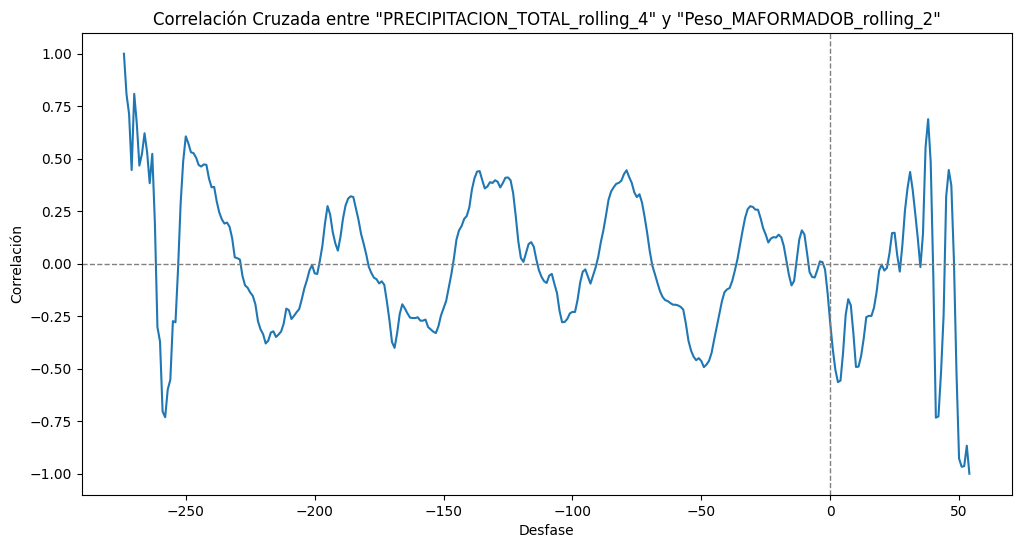

In [165]:

# Graficar correlación cruzada
plt.figure(figsize=(12, 6))
plt.plot(lags, corr)
plt.title('Correlación Cruzada entre "PRECIPITACION_TOTAL_rolling_4" y "Peso_MAFORMADOB_rolling_2"')
plt.xlabel('Desfase')
plt.ylabel('Correlación')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.show()


In [203]:

# Probando traslaciones temporales
# -----------

# Desplazar 'VARIABLE_1' un período hacia adelante
# -- tipo A
# --
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_15'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-15)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_16'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-16)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_17'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-17)
# --
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_22'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-22)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_23'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-23)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_24'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-24)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_25'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-25)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_26'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-26)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_27'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-27)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_28'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-28)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_29'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-29)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_30'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-30)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_31'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-31)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_32'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-32)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_33'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-33)

df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_34'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-34)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_35'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-35)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_38'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-38)
# --
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_43'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-43)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_44'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-44)
# --
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_50'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-50)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_61'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-61)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_62'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-62)
df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_70'] = df_analisis_full['Peso_MAFORMADOA_rolling_2'].shift(-70)


# -- tipo B
# --
df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_8'] = df_analisis_full['Peso_MAFORMADOB_rolling_2'].shift(-8)
df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_10'] = df_analisis_full['Peso_MAFORMADOB_rolling_2'].shift(-10)
df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_11'] = df_analisis_full['Peso_MAFORMADOB_rolling_2'].shift(-11)
df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_12'] = df_analisis_full['Peso_MAFORMADOB_rolling_2'].shift(-12)
df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_13'] = df_analisis_full['Peso_MAFORMADOB_rolling_2'].shift(-13)

df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_30'] = df_analisis_full['Peso_MAFORMADOB_rolling_2'].shift(-30)
df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_31'] = df_analisis_full['Peso_MAFORMADOB_rolling_2'].shift(-31)
df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_32'] = df_analisis_full['Peso_MAFORMADOB_rolling_2'].shift(-32)

df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_35'] = df_analisis_full['Peso_MAFORMADOB_rolling_2'].shift(-35)
df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_43'] = df_analisis_full['Peso_MAFORMADOB_rolling_2'].shift(-43)
df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_60'] = df_analisis_full['Peso_MAFORMADOB_rolling_2'].shift(-60)


df_analisis_full.head()


,FECHA,PLANTACION,PRECIPITACION_TOTAL,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,...,Peso_MAFORMADOB_rolling_2_SHIFTED_43,Peso_MAFORMADOB_rolling_2_SHIFTED_60,Peso_MAFORMADOB_rolling_2_SHIFTED_12,Peso_MAFORMADOB_rolling_2_SHIFTED_13,Peso_MAFORMADOB_rolling_2_SHIFTED_10,Peso_MAFORMADOB_rolling_2_SHIFTED_11,Peso_MAFORMADOB_rolling_2_SHIFTED_8,Peso_MAFORMADOB_rolling_2_SHIFTED_30,Peso_MAFORMADOB_rolling_2_SHIFTED_31,Peso_MAFORMADOB_rolling_2_SHIFTED_32
0,2019-03-04,Shanuzi,860.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-03-11,Shanuzi,376.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-03-18,Shanuzi,466.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-03-25,Shanuzi,654.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-04-01,Shanuzi,677.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


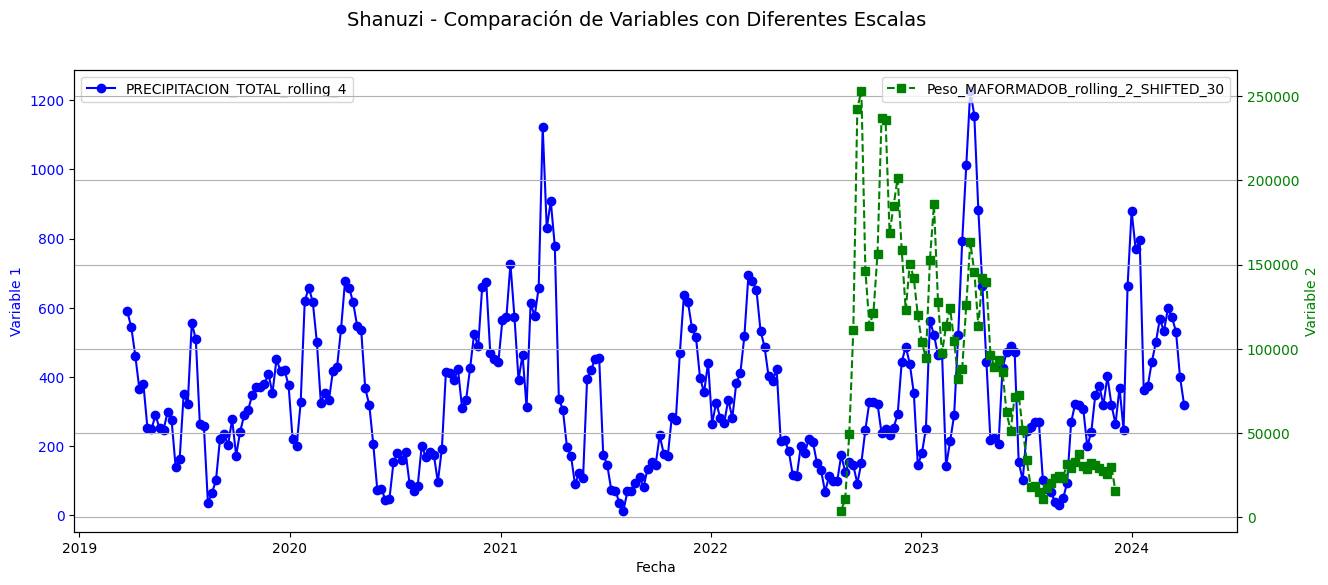

In [204]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['PRECIPITACION_TOTAL_rolling_4'], color='blue', marker='o', linestyle='-', label='PRECIPITACION_TOTAL_rolling_4')
#ax1.plot(df_analisis_full['FECHA'], df_analisis_full['% Acidez_SHIFTED_5'], color='red', marker='o', linestyle='-', label='% Acidez_SHIFTED_5')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MAFORMADOA_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MAFORMADOA_rolling_2')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_35'], color='green', marker='s', linestyle='--', label='Peso_MAFORMADOA_rolling_2_SHIFTED_43')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_60'], color='green', marker='s', linestyle='--', label='Peso_MAFORMADOA_rolling_2_SHIFTED_60')

# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_30'], color='green', marker='s', linestyle='--', label='Peso_MAFORMADOB_rolling_2_SHIFTED_30')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_16'], color='green', marker='s', linestyle='--', label='Peso_MAFORMADOB_rolling_2_SHIFTED_16')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_35'], color='green', marker='s', linestyle='--', label='Peso_MAFORMADOB_rolling_2_SHIFTED_35')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_43'], color='green', marker='s', linestyle='--', label='Peso_MAFORMADOB_rolling_2_SHIFTED_43')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_60'], color='green', marker='s', linestyle='--', label='Peso_MAFORMADOB_rolling_2_SHIFTED_60')



ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [206]:
# tipo A
# df_analisis_full['PRECIPITACION_TOTAL_rolling_4'].corr(df_analisis_full['Peso_MAFORMADOA_rolling_2'])
# df_analisis_full['PRECIPITACION_TOTAL_rolling_4'].corr(df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_15'])
# df_analisis_full['PRECIPITACION_TOTAL_rolling_4'].corr(df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_35'])
# df_analisis_full['PRECIPITACION_TOTAL_rolling_4'].corr(df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_43'])

# -- tipo B
df_analisis_full['PRECIPITACION_TOTAL_rolling_4'].corr(df_analisis_full['Peso_MAFORMADOB_rolling_2'])
# df_analisis_full['PRECIPITACION_TOTAL_rolling_4'].corr(df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_30'])
# df_analisis_full['PRECIPITACION_TOTAL_rolling_4'].corr(df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_35'])
# df_analisis_full['PRECIPITACION_TOTAL_rolling_4'].corr(df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_43'])
# df_analisis_full['PRECIPITACION_TOTAL_rolling_4'].corr(df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_60'])

# df_segmentos_full['PRECIPITACION_TOTAL_rolling_4'].corr(df_segmentos_full['Peso_MAFORMADOB_rolling_2_SHIFTED_8'])



-0.2812378892069442

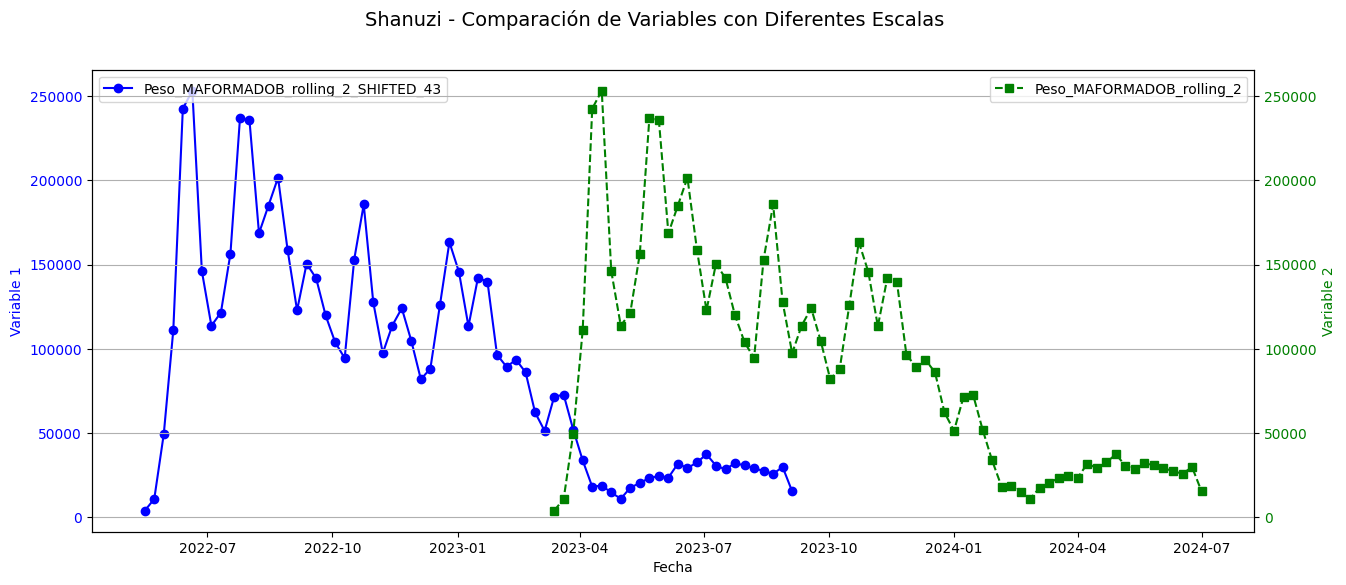

In [145]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
#ax1.plot(df_analisis_full['FECHA'], df_analisis_full['% Acidez'], color='blue', marker='o', linestyle='-', label='% Acidez')
# ax1.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_60'], color='blue', marker='o', linestyle='-', label='Peso_MAFORMADOA_rolling_2_SHIFTED_60')
# ax1.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MAFORMADOA_rolling_2_SHIFTED_43'], color='blue', marker='o', linestyle='-', label='Peso_MAFORMADOA_rolling_2_SHIFTED_43')
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MAFORMADOB_rolling_2_SHIFTED_43'], color='blue', marker='o', linestyle='-', label='Peso_MAFORMADOB_rolling_2_SHIFTED_43')

ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MAFORMADOA_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MAFORMADOA_rolling_2')
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MAFORMADOB_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MAFORMADOB_rolling_2')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()


##### RELACION CALIDAD FRUTOS VS TEA

In [40]:
df_calidad_racimos_propios_full.head()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MAFORMADOA,Peso_MAFORMADOB
0,2021-08-18,Palmawasi,55.0,1978.0,62.0,0.0,0.0,45.0,5.0,NaN,NaN,2095.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-19,Palmawasi,91.0,2100.0,91.0,0.0,0.0,89.0,9.0,NaN,NaN,2282.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-08-20,Palmawasi,49.0,1776.0,78.0,9.0,0.0,52.0,6.0,NaN,NaN,1903.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-08-21,Palmawasi,35.0,2033.0,113.0,0.0,0.0,62.0,4.0,NaN,NaN,2181.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-08-23,Palmawasi,43.0,1288.0,121.0,0.0,0.0,41.0,3.0,NaN,NaN,1452.0,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Creando variables de calidad
df_calidad_racimos_propios_full['Peso_CALIDAD'] = df_calidad_racimos_propios_full[['VERDES','MADUROS','SMADUROS','ESCOBAJO']].sum(axis=1)

df_calidad_racimos_propios_full['Peso_VERDES'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['VERDES']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])
df_calidad_racimos_propios_full['Peso_MADUROS'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['MADUROS']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])
df_calidad_racimos_propios_full['Peso_SMADUROS'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['SMADUROS']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])
df_calidad_racimos_propios_full['Peso_ESCOBAJO'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['ESCOBAJO']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])

df_calidad_racimos_propios_full['Peso_MAFORMADOA'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['MALFORMADOA']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])
df_calidad_racimos_propios_full['Peso_MAFORMADOB'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['MALFORMADOB']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])

df_calidad_racimos_propios_full.head()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MAFORMADOA,Peso_MAFORMADOB
0,2021-08-18,Palmawasi,55.0,1978.0,62.0,0.0,0.0,45.0,5.0,NaN,NaN,2095.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-19,Palmawasi,91.0,2100.0,91.0,0.0,0.0,89.0,9.0,NaN,NaN,2282.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-08-20,Palmawasi,49.0,1776.0,78.0,9.0,0.0,52.0,6.0,NaN,NaN,1903.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-08-21,Palmawasi,35.0,2033.0,113.0,0.0,0.0,62.0,4.0,NaN,NaN,2181.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-08-23,Palmawasi,43.0,1288.0,121.0,0.0,0.0,41.0,3.0,NaN,NaN,1452.0,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df_calidad_racimos_propios_full['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_full['FECHA'])

In [43]:
df_calidad_racimos_propios_full.PLANTACION.unique()

array(['Palmawasi', 'Nuevo Horizonte', 'Shanuzi'], dtype=object)

In [44]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
# fecha_limite = pd.Timestamp('2022-01-01') ## --> Para sede Palmawasi 
fecha_limite = pd.Timestamp('2023-04-01') ## --> Para sede Shanuzi 

# df_filtrado = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Palmawasi'][df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Palmawasi']['FECHA'] >= fecha_limite]
df_filtrado = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi'][df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi']['FECHA'] >= fecha_limite]


Analisis de  2023-04-01 00:00:00  hasta  2024-07-06 00:00:00


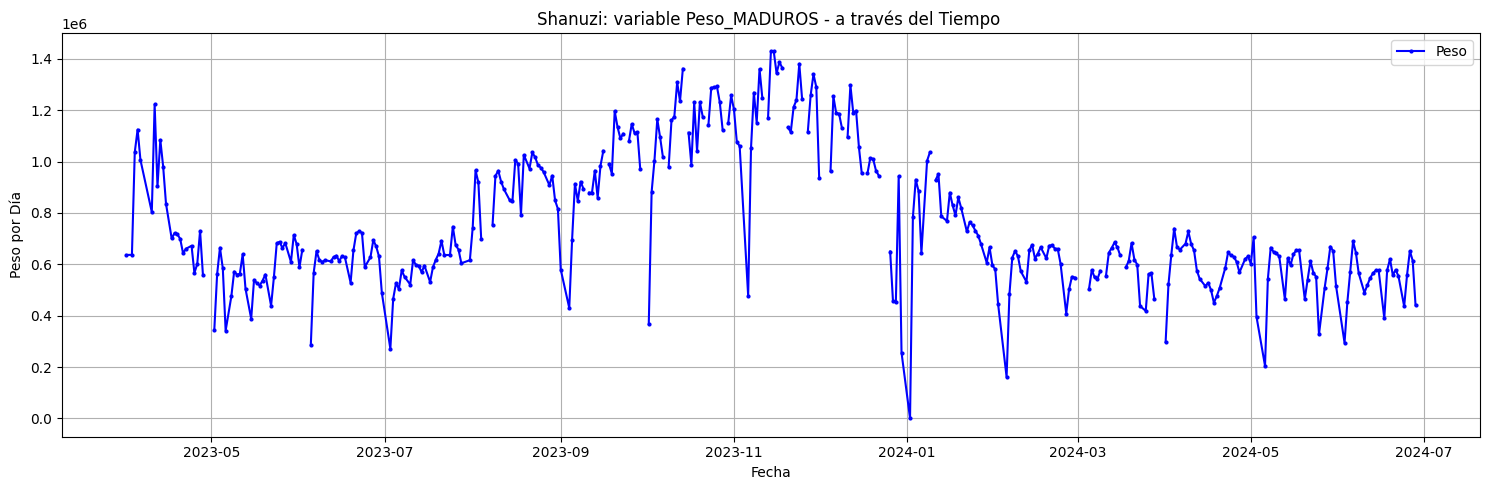

In [45]:
# function_tendencia_unica(df_calidad_racimos_propios_full,'Peso_MADUROS','blue')
function_tendencia_unica(df_filtrado,'Peso_MADUROS','blue')

In [46]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_tendencia_2 = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi']
df_analisis_tendencia_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_2['FECHA'])

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_20696\116925616.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_2['FECHA'])


In [47]:
# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2['SEMANA'] = df_analisis_tendencia_2['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_analisis_tendencia_2.head()


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_20696\1360649808.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_2['SEMANA'] = df_analisis_tendencia_2['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MAFORMADOA,Peso_MAFORMADOB,SEMANA
56,2022-01-03,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.400986e+05,55872.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-03
59,2022-01-04,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.082831e+06,71622.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-03
62,2022-01-05,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.017149e+06,74650.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-03
65,2022-01-06,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.095006e+06,74774.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-03
68,2022-01-07,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.608574e+05,60555.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-03


In [49]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_tendencia_semana_2 = df_analisis_tendencia_2.groupby(['SEMANA','PLANTACION']).agg({'Peso': 'sum',
                                                                                             'Racimos':'sum',
                                                                                             'Peso_CALIDAD':'sum',
                                                                                             'Peso_VERDES':'sum',
                                                                                             'Peso_MADUROS':'sum',
                                                                                             'Peso_SMADUROS':'sum',
                                                                                             'Peso_ESCOBAJO':'sum',
                                                                                             'Peso_MAFORMADOA':'sum',
                                                                                             'Peso_MAFORMADOB':'sum'}).reset_index()

df_analisis_tendencia_semana_2.columns = ['FECHA', 'PLANTACION', 'Peso', 'Racimos', 'Peso_CALIDAD','Peso_VERDES', 'Peso_MADUROS', 'Peso_SMADUROS', 'Peso_ESCOBAJO','Peso_MAFORMADOA','Peso_MAFORMADOB']
df_analisis_tendencia_semana_2.head()

,FECHA,PLANTACION,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MAFORMADOA,Peso_MAFORMADOB
0,2022-01-03,Shanuzi,4.451012e+06,341051.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-01-10,Shanuzi,5.039059e+06,350212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-01-17,Shanuzi,6.533269e+06,449793.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-01-24,Shanuzi,5.390967e+06,373554.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-01-31,Shanuzi,5.702007e+06,297405.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
# fecha_limite = pd.Timestamp('2022-01-01') ## --> Para sede Palmawasi 
fecha_limite = pd.Timestamp('2023-04-01') ## --> Para sede Shanusi

df_filtrado_2 = df_analisis_tendencia_semana_2[df_analisis_tendencia_semana_2['FECHA'] > fecha_limite]
df_filtrado_2.PLANTACION.unique()


array(['Shanuzi'], dtype=object)

Analisis de  2023-04-03 00:00:00  hasta  2024-07-01 00:00:00


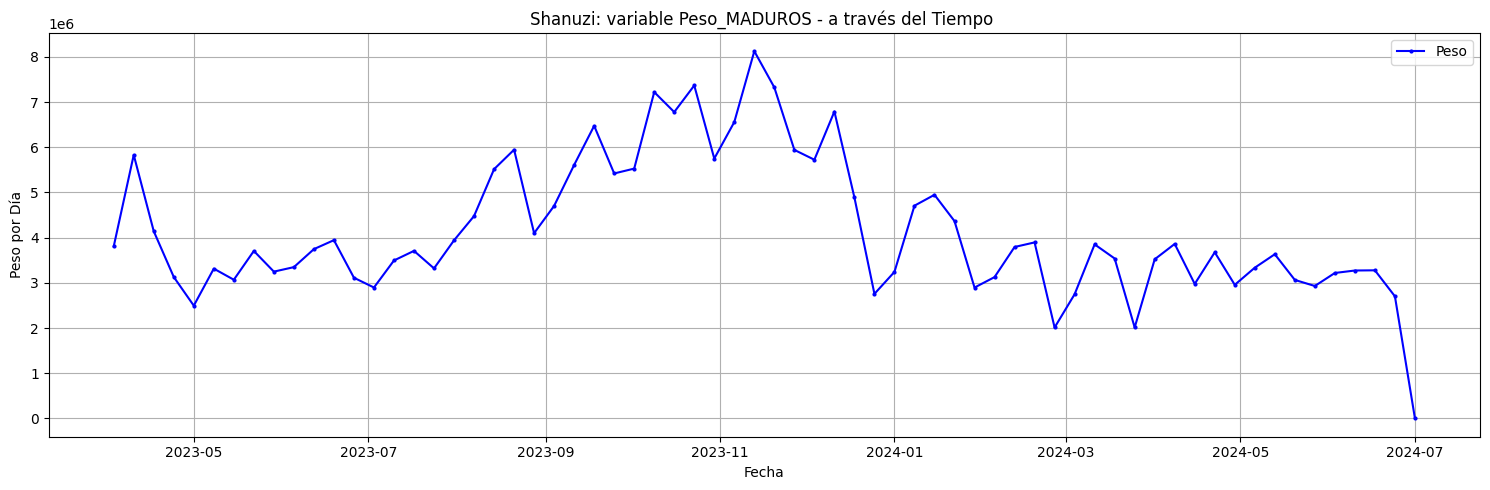

In [51]:
# function_tendencia_unica(df_analisis_tendencia_semana_2,'Peso_MADUROS','blue')
function_tendencia_unica(df_filtrado_2,'Peso_MADUROS','blue')

TEA MENSUAL

In [52]:
# Creando variable TEA
# -----
df_participacion_cashcost_full['TEA'] = df_participacion_cashcost_full['CPOObtenido']/df_participacion_cashcost_full['RFFProcesado']

In [53]:
df_participacion_cashcost_full[df_participacion_cashcost_full['PLANTACION'] == 'Shanuzi'].head()

,pk_tiempo,vch_centro,SEDE,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,CPOObtenidoPropios,CPOObtenidoTerceros,FECHA,PLANTACION,TEA
3,20190102,3702,SH,109.94,102.72,7.22,24.56,24.06793,0.49207,2019-01-02,Shanuzi,0.223395
6,20190103,3702,SH,673.98,652.58,21.40,167.02,163.67371,3.34629,2019-01-03,Shanuzi,0.247812
9,20190104,3702,SH,1075.50,1054.55,20.95,272.28,266.82479,5.45521,2019-01-04,Shanuzi,0.253166
12,20190105,3702,SH,508.95,494.13,14.82,150.43,147.41609,3.01391,2019-01-05,Shanuzi,0.295569
15,20190106,3702,SH,0.00,0.00,0.00,0.00,0.00000,0.00000,2019-01-06,Shanuzi,NaN


Analisis de  2019-01-02  hasta  2024-06-30


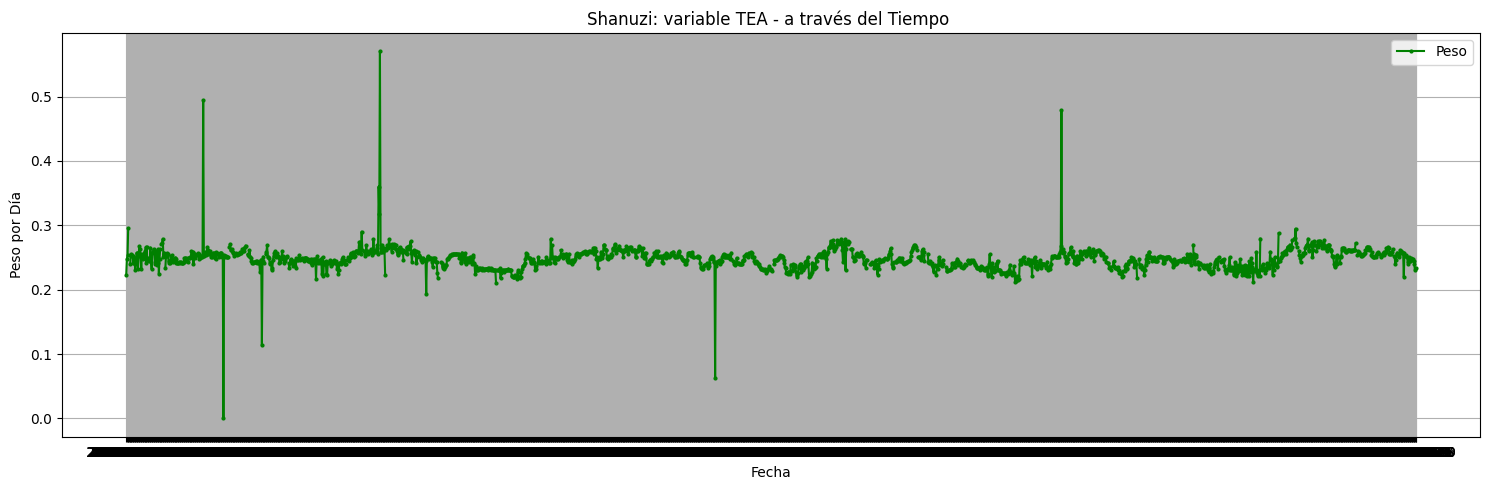

In [54]:
# function_tendencia_unica(df_participacion_cashcost_full[df_participacion_cashcost_full['PLANTACION'] == 'Palmawasi'], 'TEA')
function_tendencia_unica(df_participacion_cashcost_full[df_participacion_cashcost_full['PLANTACION'] == 'Shanuzi'], 'TEA')

In [55]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

# df_analisis_tendencia = df_participacion_cashcost_full[df_participacion_cashcost_full['PLANTACION'] == 'Palmawasi']
df_analisis_tendencia = df_participacion_cashcost_full[df_participacion_cashcost_full['PLANTACION'] == 'Shanuzi']

df_analisis_tendencia['FECHA'] = pd.to_datetime(df_analisis_tendencia['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia['SEMANA'] = df_analisis_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_analisis_tendencia.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_20696\857858933.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia['FECHA'] = pd.to_datetime(df_analisis_tendencia['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_20696\857858933.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia['SEMANA'] = df_analisis_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,pk_tiempo,vch_centro,SEDE,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,CPOObtenidoPropios,CPOObtenidoTerceros,FECHA,PLANTACION,TEA,SEMANA
3,20190102,3702,SH,109.94,102.72,7.22,24.56,24.06793,0.49207,2019-01-02,Shanuzi,0.223395,2018-12-31
6,20190103,3702,SH,673.98,652.58,21.40,167.02,163.67371,3.34629,2019-01-03,Shanuzi,0.247812,2018-12-31
9,20190104,3702,SH,1075.50,1054.55,20.95,272.28,266.82479,5.45521,2019-01-04,Shanuzi,0.253166,2018-12-31
12,20190105,3702,SH,508.95,494.13,14.82,150.43,147.41609,3.01391,2019-01-05,Shanuzi,0.295569,2018-12-31
15,20190106,3702,SH,0.00,0.00,0.00,0.00,0.00000,0.00000,2019-01-06,Shanuzi,NaN,2018-12-31


In [57]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_tendencia_semana = df_analisis_tendencia.groupby(['SEMANA','PLANTACION']).agg({'RFFProcesado': 'sum',
                                                                                           'CPOObtenido': 'sum'}).reset_index()
df_analisis_tendencia_semana.columns = ['FECHA','PLANTACION','RFFProcesado','CPOObtenido']
df_analisis_tendencia_semana['TEA'] = df_analisis_tendencia_semana['CPOObtenido']/df_analisis_tendencia_semana['RFFProcesado']

print(df_analisis_tendencia_semana.PLANTACION.unique())
df_analisis_tendencia_semana.head()


['Shanuzi']


,FECHA,PLANTACION,RFFProcesado,CPOObtenido,TEA
0,2018-12-31,Shanuzi,2368.37,614.290,0.259372
1,2019-01-07,Shanuzi,3617.40,903.559,0.249781
2,2019-01-14,Shanuzi,4440.89,1086.792,0.244724
3,2019-01-21,Shanuzi,4561.70,1145.254,0.251059
4,2019-01-28,Shanuzi,4127.80,1056.443,0.255934


Analisis de  2018-12-31 00:00:00  hasta  2024-06-24 00:00:00


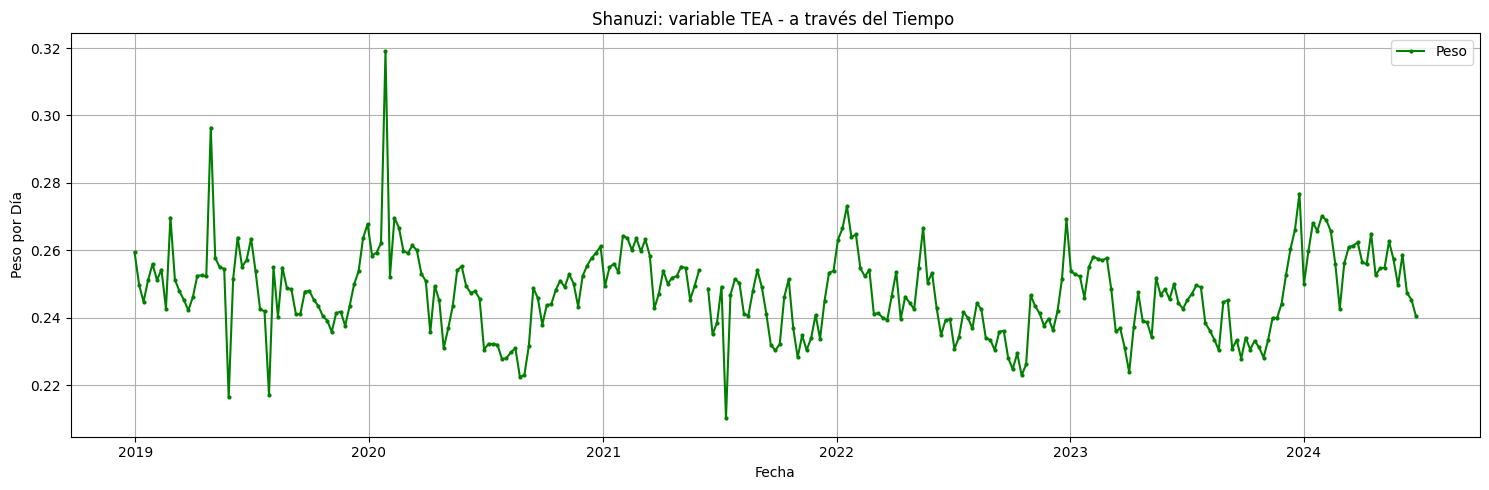

In [58]:
function_tendencia_unica(df_analisis_tendencia_semana, 'TEA')

Analisis de  2018-12-31 00:00:00  hasta  2024-06-24 00:00:00


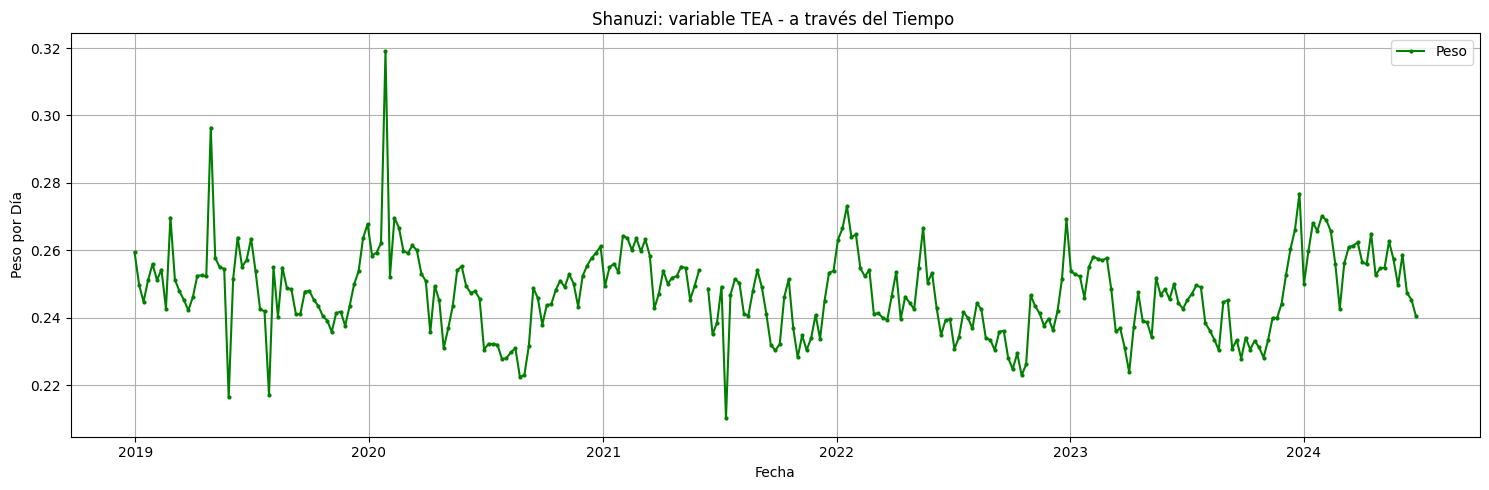

In [29]:
function_tendencia_unica(df_analisis_tendencia_semana, 'TEA')

In [30]:
# Filtrar el DataFrame para considerar solo las fechas mayores a ...
# fecha_limite = pd.Timestamp('2022-01-01') ## --> Para sede Palmawasi 
fecha_limite = pd.Timestamp('2023-04-01') ## --> Para sede Shanuzi 

df_filtrado_3 = df_analisis_tendencia_semana[df_analisis_tendencia_semana['FECHA'] > fecha_limite]
df_filtrado_3.head()


,FECHA,PLANTACION,RFFProcesado,CPOObtenido,TEA
222,2023-04-03,Shanuzi,3779.589,845.813,0.223784
223,2023-04-10,Shanuzi,5058.020,1199.336,0.237116
224,2023-04-17,Shanuzi,5506.700,1363.026,0.247521
225,2023-04-24,Shanuzi,4367.280,1044.245,0.239106
226,2023-05-01,Shanuzi,2963.642,707.017,0.238564


In [31]:

# AÑADIENDO DATOS DE BALANZA Y FABRICA
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_full = pd.merge(df_filtrado_3,
                            df_filtrado_2,
                            on=['FECHA', 'PLANTACION'], how='outer')
# Convertir 'FECHA' a formato datetime
df_analisis_full['FECHA'] = pd.to_datetime(df_analisis_full['FECHA'])
print(df_analisis_full.PLANTACION.unique())
df_analisis_full.head()

['Shanuzi']


,FECHA,PLANTACION,RFFProcesado,CPOObtenido,TEA,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MAFORMADOA,Peso_MAFORMADOB
0,2023-04-03,Shanuzi,3779.589,845.813,0.223784,4.606009e+06,212737.0,9958.0,48925.265276,3.804805e+06,7.522783e+05,0.000000,210264.605885,137284.673061
1,2023-04-10,Shanuzi,5058.020,1199.336,0.237116,7.096402e+06,315666.0,17797.0,54024.035448,5.831108e+06,1.123499e+06,87770.896357,360567.942485,347944.656024
2,2023-04-17,Shanuzi,5506.700,1363.026,0.247521,5.211240e+06,329493.0,18654.0,42506.304719,4.141709e+06,9.633837e+05,63640.621034,153850.878766,158480.531514
3,2023-04-24,Shanuzi,4367.280,1044.245,0.239106,3.942410e+06,262386.0,15174.0,29223.498012,3.129246e+06,7.084297e+05,47418.257892,108980.006180,133836.709053
4,2023-05-01,Shanuzi,2963.642,707.017,0.238564,3.276175e+06,211722.0,12455.0,6767.009984,2.494688e+06,7.249435e+05,49776.683291,112368.149941,93696.058795


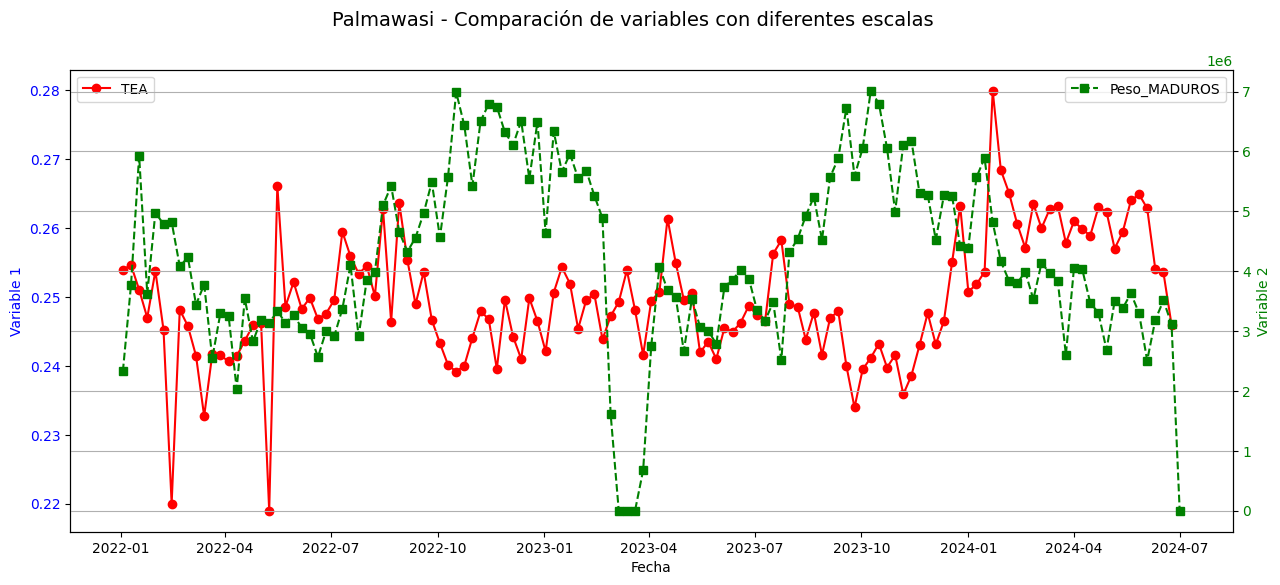

In [388]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['TEA'], color='red', marker='o', linestyle='-', label='TEA')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MADUROS'], color='green', marker='s', linestyle='--', label='Peso_MADUROS')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de variables con diferentes escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()


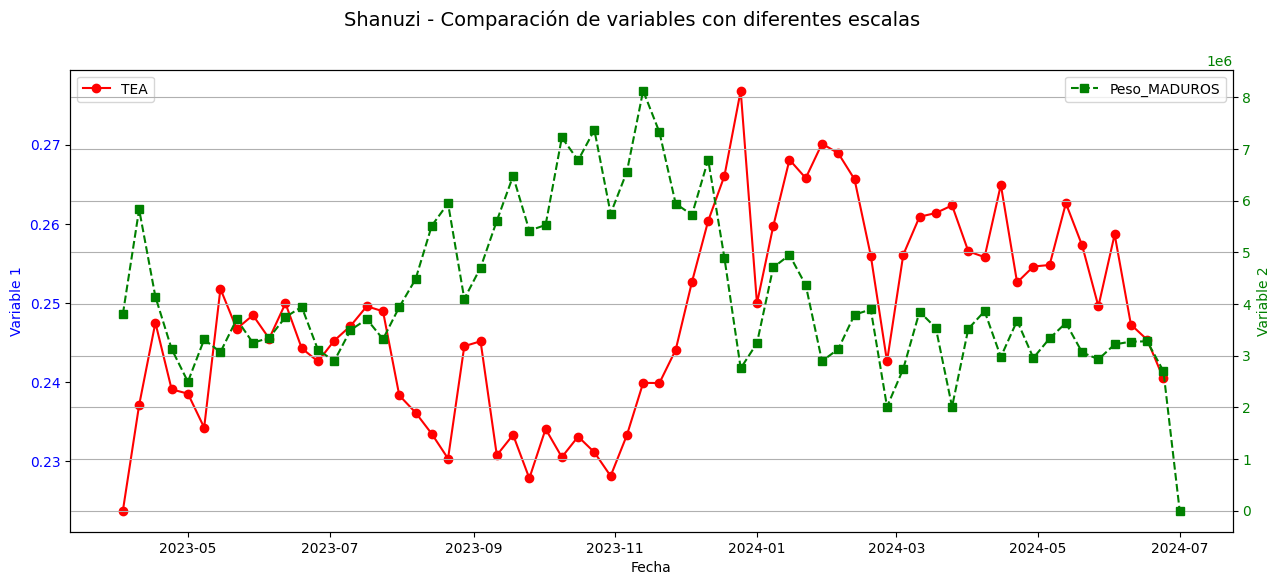

In [32]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['TEA'], color='red', marker='o', linestyle='-', label='TEA')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MADUROS'], color='green', marker='s', linestyle='--', label='Peso_MADUROS')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de variables con diferentes escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()


In [33]:
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_full['TEA_rolling_2'] = df_analisis_full['TEA'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['TEA_rolling_3'] = df_analisis_full['TEA'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['TEA_rolling_4'] = df_analisis_full['TEA'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['Peso_SMADUROS_rolling_2'] = df_analisis_full['Peso_SMADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_SMADUROS_rolling_3'] = df_analisis_full['Peso_SMADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_SMADUROS_rolling_4'] = df_analisis_full['Peso_SMADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['Peso_MADUROS_rolling_2'] = df_analisis_full['Peso_MADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_MADUROS_rolling_3'] = df_analisis_full['Peso_MADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_MADUROS_rolling_4'] = df_analisis_full['Peso_MADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos


df_analisis_full['Peso_VERDES_rolling_2'] = df_analisis_full['Peso_VERDES'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_VERDES_rolling_3'] = df_analisis_full['Peso_VERDES'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_VERDES_rolling_4'] = df_analisis_full['Peso_VERDES'].rolling(window=4).mean() # Suavizado a 4 periodos
df_analisis_full['Peso_VERDES_rolling_5'] = df_analisis_full['Peso_VERDES'].rolling(window=5).mean() # Suavizado a 4 periodos


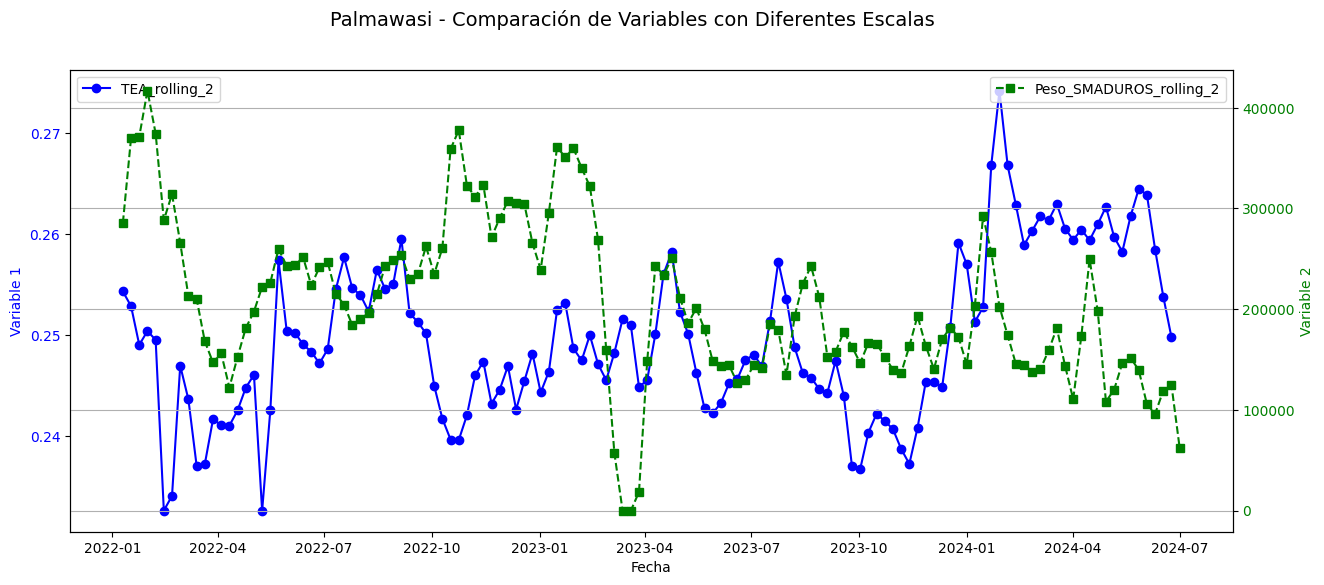

In [397]:

# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
# ax1.plot(df_analisis_full['FECHA'], df_analisis_full['TEA'], color='blue', marker='o', linestyle='-', label='TEA')
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['TEA_rolling_2'], color='blue', marker='o', linestyle='-', label='TEA_rolling_2')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MADUROS_rolling_2')
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_SMADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS_rolling_2')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_VERDES')


ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

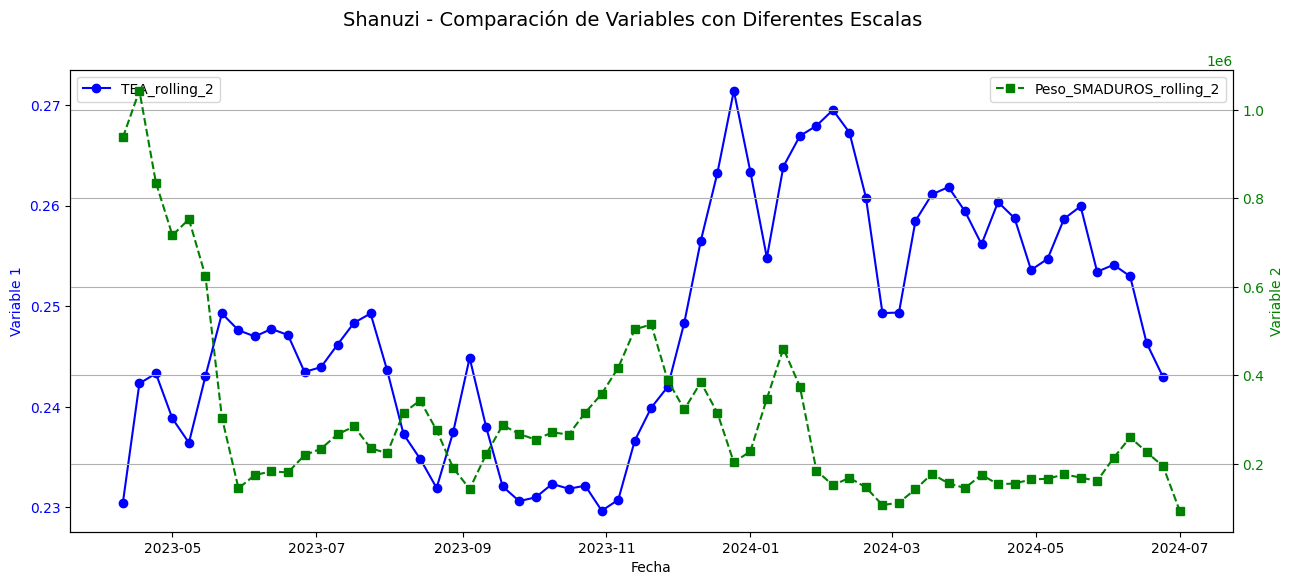

In [34]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
# ax1.plot(df_analisis_full['FECHA'], df_analisis_full['TEA'], color='blue', marker='o', linestyle='-', label='TEA')
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['TEA_rolling_2'], color='blue', marker='o', linestyle='-', label='TEA_rolling_2')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MADUROS_rolling_2')
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_SMADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS_rolling_2')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_VERDES')


ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [35]:
# df_analisis_full['TEA'].corr(df_analisis_full['Peso_MADUROS_rolling_2'])
df_analisis_full['TEA'].corr(df_analisis_full['Peso_SMADUROS_rolling_2'])
# df_analisis_full['TEA'].corr(df_analisis_full['Peso_VERDES_rolling_2'])

# df_analisis_full['TEA_rolling_2'].corr(df_analisis_full['Peso_MADUROS_rolling_2'])


-0.2942614864496017

In [36]:
def function_correlacion_cruzada(df_x):
    # Excluir la columna 'TEA' para calcular la correlación con las variables explicativas temporales
    df_explicativas = df_x.drop(columns=['TEA'])

    # Calcular la correlación entre TEA y cada variable explicativa temporal utilizando rolling().corr()
    correlation_df = df_explicativas.rolling(window=10).corr(df_x['TEA'])

    # Mostrar el DataFrame de correlaciones
    print(correlation_df)

    # Crear un gráfico de calor para visualizar las correlaciones
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_df.T, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlación entre TEA y Variables Explicativas Temporales')
    plt.xlabel('Puntos Temporales')
    plt.ylabel('Variables Explicativas Temporales')
    plt.show()

In [401]:
df_analisis_full.columns

Index(['FECHA', 'PLANTACION', 'RFFProcesado', 'CPOObtenido', 'TEA', 'Peso',
       'Racimos', 'Peso_CALIDAD', 'Peso_VERDES', 'Peso_MADUROS',
       'Peso_SMADUROS', 'Peso_ESCOBAJO', 'Peso_MAFORMADOA', 'Peso_MAFORMADOB',
       'TEA_rolling_2', 'TEA_rolling_3', 'TEA_rolling_4',
       'Peso_SMADUROS_rolling_2', 'Peso_SMADUROS_rolling_3',
       'Peso_SMADUROS_rolling_4', 'Peso_MADUROS_rolling_2',
       'Peso_MADUROS_rolling_3', 'Peso_MADUROS_rolling_4',
       'Peso_VERDES_rolling_2', 'Peso_VERDES_rolling_3',
       'Peso_VERDES_rolling_4', 'Peso_VERDES_rolling_5'],
      dtype='object')

In [37]:
df_analisis_full_corr_columns = ['FECHA','CPOObtenido', 'TEA','Peso_VERDES', 'Peso_MADUROS','Peso_SMADUROS', 'Peso_ESCOBAJO', 'Peso_MAFORMADOA', 'Peso_MAFORMADOB']

df_analisis_full_corr = df_analisis_full[df_analisis_full_corr_columns]
df_analisis_full_corr.set_index('FECHA', inplace=True)

df_analisis_full_corr.head()


,CPOObtenido,TEA,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MAFORMADOA,Peso_MAFORMADOB
FECHA,,,,,,,,
2023-04-03,845.813,0.223784,48925.265276,3.804805e+06,7.522783e+05,0.000000,210264.605885,137284.673061
2023-04-10,1199.336,0.237116,54024.035448,5.831108e+06,1.123499e+06,87770.896357,360567.942485,347944.656024
2023-04-17,1363.026,0.247521,42506.304719,4.141709e+06,9.633837e+05,63640.621034,153850.878766,158480.531514
2023-04-24,1044.245,0.239106,29223.498012,3.129246e+06,7.084297e+05,47418.257892,108980.006180,133836.709053
2023-05-01,707.017,0.238564,6767.009984,2.494688e+06,7.249435e+05,49776.683291,112368.149941,93696.058795


In [38]:
# Calcular la matriz de correlación entre las variables
matriz_correlacion = df_analisis_full_corr.corr()

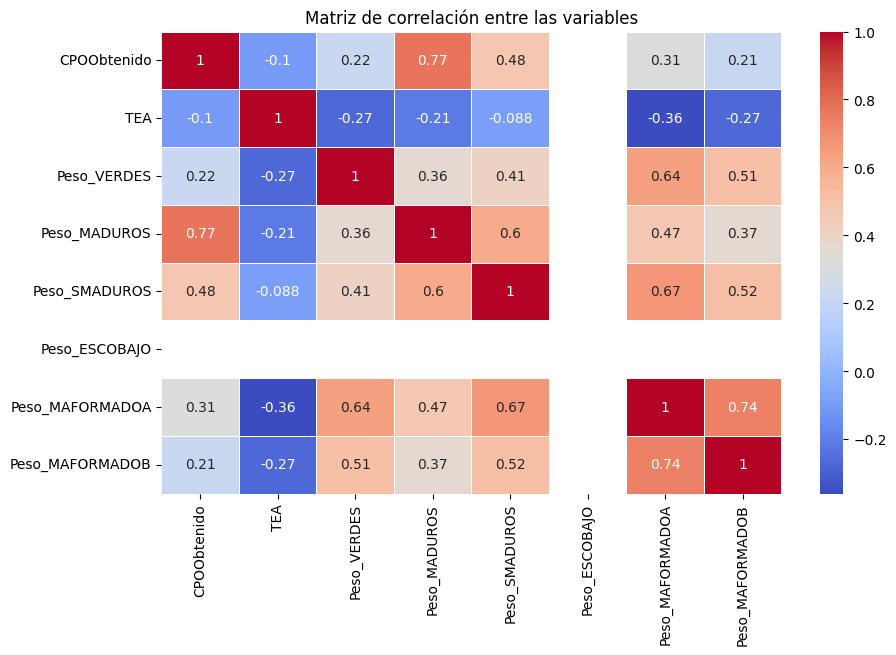

In [406]:

plt.figure(figsize=(10, 6))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de correlación entre las variables')
plt.show()

            CPOObtenido  Peso_VERDES  Peso_MADUROS  Peso_SMADUROS  \
FECHA                                                               
2023-04-03          NaN          NaN           NaN            NaN   
2023-04-10          NaN          NaN           NaN            NaN   
2023-04-17          NaN          NaN           NaN            NaN   
2023-04-24          NaN          NaN           NaN            NaN   
2023-05-01          NaN          NaN           NaN            NaN   
...                 ...          ...           ...            ...   
2024-06-03    -0.179173     0.436980      0.014149       0.012123   
2024-06-10    -0.106157     0.437965      0.026348      -0.312309   
2024-06-17    -0.217766     0.496984     -0.001113      -0.327129   
2024-06-24     0.509072     0.562167      0.517578      -0.084026   
2024-07-01          NaN          NaN           NaN            NaN   

            Peso_ESCOBAJO  Peso_MAFORMADOA  Peso_MAFORMADOB  
FECHA                                   

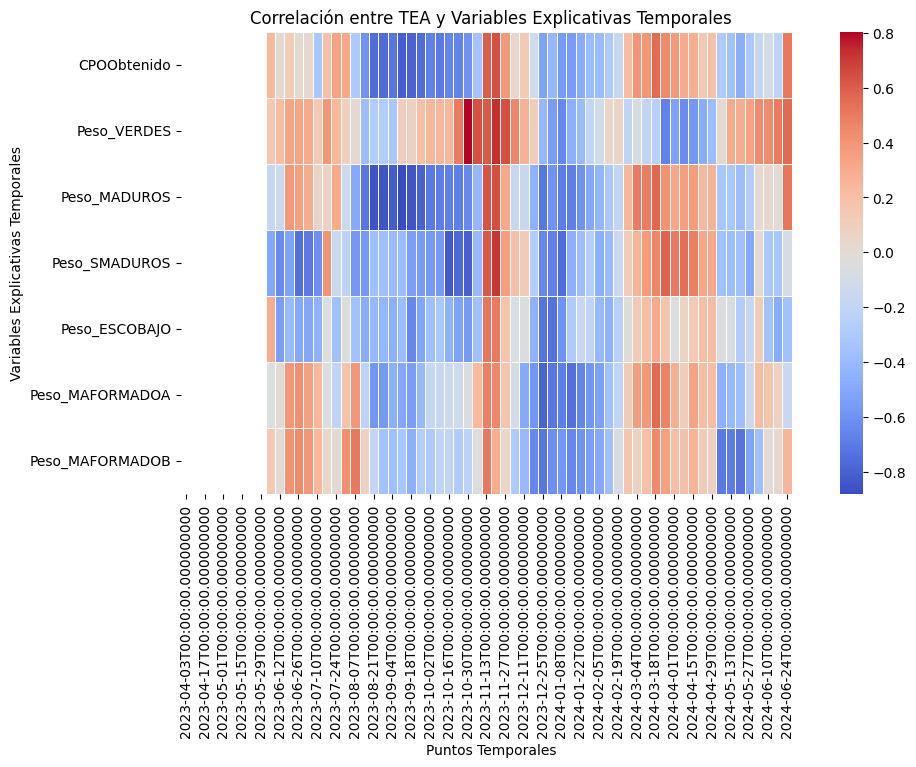

In [39]:
function_correlacion_cruzada(df_analisis_full_corr)

##### OTRO ANALISIS

In [ ]:
# Analizando datos por Plantacion
# ----
df_TEA_full_tendencia = df_calidad_racimos_propios_full_group[df_calidad_racimos_propios_full_group['PLANTACION'] == 'Palmawasi']
# ---
df_TEA_full_tendencia = df_TEA_full_tendencia[df_TEA_full_tendencia['SECTOR'] == 'SE03']
# ---

function_tendencia_unica(df_TEA_full_tendencia,'Peso')

In [ ]:
df_TEA_full.head()

In [ ]:
print(df_TEA_full['PLANTACION'].unique())
df_TEA_full.head()

In [ ]:
function_tendencia_unica(df_TEA_full[df_TEA_full['PLANTACION'] == 'Nuevo Horizonte'], 'PROPIOS')

In [ ]:
# Filtramos la tendencia de interes DE LA BBDD UNIDA
# ################
# ################
# ################

# ---
df_TEA_full_tendencia = df_TEA_full[df_TEA_full['PLANTACION'] == 'Nuevo Horizonte']
df_TEA_full_tendencia = df_TEA_full_tendencia.sort_values(by='FECHA')
# ---

plantacion_name = df_TEA_full_tendencia['PLANTACION'].unique()

# Crear el gráfico de líneas para 'toneladas_dia'
plt.figure(figsize=(15, 5))
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['CPO OBTENIDO'], marker='o', markersize=2, linestyle='-', color='green', label='CPO OBTENIDO')
plt.title('RFF Procesado por Día a través del Tiempo - '+ plantacion_name[0])
plt.xlabel('Fecha')
plt.ylabel('RFF Procesado por Día')
plt.grid(True)
plt.legend()
#plt.xticks(rotation=45)

# Mostrar la gráfica
# print(df_TEA_full_tendencia[df_TEA_full_tendencia['RFF PROCESADO'] == 0].head())
plt.tight_layout()
plt.show()

In [ ]:
# ---
plantacion_name = df_TEA_full_tendencia['PLANTACION'].unique()


# Configurar el gráfico
plt.figure(figsize=(15, 5))

# Graficar 'VALOR1' y 'VALOR2'
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['RFF PROCESADO'], marker='o', markersize=4, label='RFF PROCESADO')
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['CPO OBTENIDO'], marker='o', markersize=4, label='CPO OBTENIDO')

# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['PROPIOS'], marker='o', markersize=4, label='PROPIOS')
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['TERCEROS'], marker='o', markersize=4, label='TERCEROS')
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['PRECIPITACION_TOTAL'], marker='o', markersize=4, label='PRECIPITACION_TOTAL')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('Comparación de RFF PROCESADO y CPO OBTENIDO a lo largo del tiempo - '+ plantacion_name[0])
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [ ]:
# Duplicando informacion faltante
# -----
df_TEA_full_tendencia_recorte = df_TEA_full_tendencia[['FECHA','CPO OBTENIDO']]
df_TEA_full_tendencia_recorte = df_TEA_full_tendencia_recorte.dropna(subset=['CPO OBTENIDO'])
df_TEA_full_tendencia_recorte = df_TEA_full_tendencia_recorte[df_TEA_full_tendencia_recorte['FECHA'] <= '2023-12-31']
# Lista de años a los que quieres copiar los datos
years_to_fill = [2019, 2020, 2021, 2022]

dfs_real = df_TEA_full_tendencia[['FECHA','CPO OBTENIDO']][df_TEA_full_tendencia['FECHA'] > '2023-01-01']

dfs = []
for year in years_to_fill:
    df_copy = df_TEA_full_tendencia_recorte.copy()
    # Ajustar el año mientras se maneja el caso especial del 29 de febrero
    def replace_year(date):
        try:
            return date.replace(year=year)
        except ValueError:
            # Manejar el 29 de febrero para años no bisiestos
            return date.replace(year=year, day=28)
    
    df_copy['FECHA'] = df_copy['FECHA'].apply(replace_year)
    dfs.append(df_copy)

# Concatenar todos los DataFrames
df_combined = pd.concat(dfs, ignore_index=True)
df_final = pd.concat([df_combined,dfs_real], ignore_index=True)

df_final.columns = ['FECHA','CPO OBTENIDO imp']
df_final.head()

In [ ]:
# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full_tendencia = pd.merge(df_TEA_full_tendencia,
                                 df_final, 
                                 on='FECHA', 
                                 how='left')

In [ ]:
df_TEA_full_tendencia.head()

In [ ]:
plantacion_name = df_TEA_full_tendencia['PLANTACION'].unique()


# Configurar el gráfico
plt.figure(figsize=(15, 5))

# Graficar 'VALOR1' y 'VALOR2'
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['RFF PROCESADO'], marker='o', markersize=4, label='RFF PROCESADO')
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['CPO OBTENIDO'], marker='o', markersize=4, label='CPO OBTENIDO')
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['CPO OBTENIDO imp'], marker='o', markersize=4, label='CPO OBTENIDO imp')


# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['PROPIOS'], marker='o', markersize=4, label='PROPIOS')
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['TERCEROS'], marker='o', markersize=4, label='TERCEROS')
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['PRECIPITACION_TOTAL'], marker='o', markersize=4, label='PRECIPITACION_TOTAL')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('Comparación de RFF PROCESADO y CPO OBTENIDO a lo largo del tiempo - '+ plantacion_name[0])
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

#### Agrupando por semanas

In [ ]:
# Crear columna 'SEMANA' que indica el año y la semana del año
df_TEA_full_tendencia['SEMANA'] = df_TEA_full_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_TEA_full_tendencia.head()

In [ ]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_TEA_full_semana = df_TEA_full_tendencia.groupby(['SEMANA', 'PLANTACION']).agg({'PROPIOS': 'sum',
                                                                                  'TERCEROS': 'sum',
                                                                                  'TOTAL': 'sum',
                                                                                  'RFF PROCESADO': 'sum',
                                                                                  'CPO OBTENIDO': 'sum',
                                                                                  'CPO OBTENIDO imp': 'sum',
                                                                                  'PRECIPITACION_TOTAL':'sum'}).reset_index()

df_TEA_full_semana.head()

#### Suavizando por medias moviles

In [ ]:
# Filtramos la tendencia de interes
# -------------

# ---
df_TEA_full_semana_tendencia = df_TEA_full_semana
df_TEA_full_semana_tendencia = df_TEA_full_semana_tendencia.sort_values(by='SEMANA')
df_TEA_full_semana_tendencia.head()

In [ ]:
# Suavizando por medias moviles
# ----------
df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_2'] = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].rolling(window=2).mean() # Suavizado a 2 periodos
df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'] = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].rolling(window=3).mean() # Suavizado a 3 periodos
df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_4'] = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].rolling(window=4).mean() # Suavizado a 4 periodos
df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_5'] = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].rolling(window=5).mean() # Suavizado a 5 periodos


df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_2'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].rolling(window=2).mean() # Suavizado a 2 periodos
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].rolling(window=3).mean() # Suavizado a 3 periodos
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_4'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].rolling(window=4).mean() # Suavizado a 4 periodos
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_5'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].rolling(window=5).mean() # Suavizado a 5 periodos


# Probando traslaciones temporales
# -----------

# Desplazar 'VARIABLE_1' un período hacia adelante
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_1'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-1)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_2'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-2)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_3'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-3)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_4'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-4)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_5'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-5)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_6'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-6)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_7'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-7)


df_TEA_full_semana_tendencia.head()

In [ ]:
# Graficamos tendencias
# -------
# -----
# --

plantacion_name = df_TEA_full_semana_tendencia['PLANTACION'].unique()

# Crear el gráfico de líneas para 'toneladas_dia'
plt.figure(figsize=(15, 5))
plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO imp'], marker='o', markersize=2, linestyle='-', color='green', label='CPO OBTENIDO')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_2'], marker='o', markersize=2, linestyle='-', color='red', label='CPO OBTENIDO_svzdo_2')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'], marker='o', markersize=2, linestyle='-', color='blue', label='CPO OBTENIDO_svzdo_3')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_4'], marker='o', markersize=2, linestyle='-', color='red', label='CPO OBTENIDO_svzdo_4')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_5'], marker='o', markersize=2, linestyle='-', color='blue', label='CPO OBTENIDO_svzdo_5')

plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_4'], marker='o', markersize=2, linestyle='-', color='blue', label='PRECIPITACION_TOTAL_SHIFTED_1')


plt.title('RFF Procesado por Semana a través del Tiempo - '+ plantacion_name[0])
plt.xlabel('Semana')
plt.ylabel('RFF Procesado por Semana')
plt.grid(True)
plt.legend()
#plt.xticks(rotation=45)

# Mostrar la gráfica
# print(df_TEA_full_semana_tendencia[df_TEA_full_semana_tendencia['RFF PROCESADO'] == 0].head())
plt.tight_layout()
plt.show()

In [ ]:
plantacion_name = df_TEA_full_semana_tendencia['PLANTACION'].unique()

# Configurar el gráfico
plt.figure(figsize=(15, 5))

# Graficar 'VALOR1' y 'VALOR2'
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['RFF PROCESADO'], marker='o', markersize=4, label='RFF PROCESADO')
plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO imp'], marker='o', markersize=4, label='CPO OBTENIDO imp')

# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['TOTAL'], marker='o', markersize=4, label='TOTAL recibido')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['PROPIOS'], marker='o', markersize=4, label='PROPIOS')
plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'], marker='o', markersize=4, label='PRECIPITACION_TOTAL')
plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_4'], marker='o', markersize=4, label='PRECIPITACION_TOTAL')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('Comparación de CPO OBTENIDO y PRECIPITACION_TOTAL a lo largo del tiempo - '+ plantacion_name[0])
plt.legend()

# Mostrar el gráfico
# Mostrar la gráfica
# print(df_TEA_full_semana_tendencia.head())
plt.grid(True)
plt.show()

In [ ]:
# Suponiendo que df es tu DataFrame y col1, col2 son las columnas de datos temporales
correlation_pearson = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'], method='pearson')
correlation_spearman = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'], method='spearman')
correlation_kendall = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'], method='kendall')

print("Correlación de Pearson:", correlation_pearson)
print("Correlación de Spearman:", correlation_spearman)
print("Correlación de Kendall:", correlation_kendall)

In [ ]:
# Suponiendo que df es tu DataFrame y col1, col2 son las columnas de datos temporales
correlation_pearson = df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'], method='pearson')
correlation_spearman = df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'], method='spearman')
correlation_kendall = df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'], method='kendall')

print("Correlación de Pearson:", correlation_pearson)
print("Correlación de Spearman:", correlation_spearman)
print("Correlación de Kendall:", correlation_kendall)

In [ ]:
# Suponiendo que df es tu DataFrame y col1, col2 son las columnas de datos temporales
correlation_pearson = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_6'], method='pearson')
correlation_spearman = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_6'], method='spearman')
correlation_kendall = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_6'], method='kendall')

print("Correlación de Pearson:", correlation_pearson)
print("Correlación de Spearman:", correlation_spearman)
print("Correlación de Kendall:", correlation_kendall)

In [ ]:
from statsmodels.tsa.stattools import coint

# Suponiendo que series1 y series2 son tus series temporales
score, p_value, _ = coint(df_TEA_full_semana_tendencia['CPO OBTENIDO imp'], df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_5'])

print("P-valor de la cointegración:", p_value)

In [ ]:
import statsmodels.api as sm


In [ ]:
import statsmodels.api as sm

# Suponiendo que df tiene 'X' como variable independiente y 'Y' como variable dependiente
X = df_TEA_full_semana_tendencia[['PRECIPITACION_TOTAL_svzdo_3']]
Y = df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3']
X = sm.add_constant(X)  # Añadir constante para la intercepción
model = sm.OLS(Y, X).fit()
print(model.summary())

#### Transformando data por Plantación

##### Planta Shanuzi

In [ ]:

print(df_TEA_full.FECHA.min())
print(df_TEA_full.FECHA.max())
print(df_TEA_full[df_TEA_full['PLANTACION'] == 'Shanuzi'].head())

print(df_sabana_saldo_campo_full_vf.FECHA.min())
print(df_sabana_saldo_campo_full_vf.FECHA.max())
print(df_sabana_saldo_campo_full_vf[df_sabana_saldo_campo_full_vf['PLANTACION'] == 'Shanuzi'].head())

In [ ]:
# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full_sh = pd.merge(df_TEA_full[df_TEA_full['PLANTACION'] == 'Shanuzi'],
                          df_sabana_saldo_campo_full_vf[df_sabana_saldo_campo_full_vf['PLANTACION'] == 'Shanuzi'],
                          on=['FECHA', 'PLANTACION'], how='inner')
# Convertir 'FECHA' a formato datetime
df_TEA_full_sh['FECHA'] = pd.to_datetime(df_TEA_full_sh['FECHA'])
df_TEA_full_sh.head(10)

In [ ]:
# Crear columna 'SEMANA' que indica el año y la semana del año
df_TEA_full_sh['SEMANA'] = df_TEA_full_sh['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_TEA_full_sh.head()

In [ ]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_TEA_full_sh_semana = df_TEA_full_sh.groupby(['SEMANA', 'PLANTACION']).agg({'PROPIOS': 'sum',
                                                                              'TERCEROS': 'sum',
                                                                              'TOTAL': 'sum',
                                                                              'RFF PROCESADO': 'sum',
                                                                              'CPO OBTENIDO': 'sum',
                                                                              'SALDO':'mean',
                                                                              'SALDO > 3':'mean',
                                                                              'PRECIPITACION_TOTAL':'sum'}).reset_index()

df_TEA_full_sh_semana.head()

In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

# Graficar la primera variable en el eje principal
ax1.plot(df_TEA_full_sh_semana['SEMANA'], df_TEA_full_sh_semana['PRECIPITACION_TOTAL'], color='blue', marker='o', linestyle='-', label='PRECIPITACION_TOTAL')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_TEA_full_sh_semana['SEMANA'], df_TEA_full_sh_semana['CPO OBTENIDO'], color='green', marker='s', linestyle='--', label='CPO OBTENIDO')
ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle('Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
# Suponiendo que df es tu DataFrame y col1, col2 son las columnas de datos temporales
correlation_pearson = df_TEA_full_sh_semana['CPO OBTENIDO'].corr(df_TEA_full_sh_semana['PRECIPITACION_TOTAL'], method='pearson')
correlation_spearman = df_TEA_full_sh_semana['CPO OBTENIDO'].corr(df_TEA_full_sh_semana['PRECIPITACION_TOTAL'], method='spearman')
correlation_kendall = df_TEA_full_sh_semana['CPO OBTENIDO'].corr(df_TEA_full_sh_semana['PRECIPITACION_TOTAL'], method='kendall')

print("Correlación de Pearson:", correlation_pearson)
print("Correlación de Spearman:", correlation_spearman)
print("Correlación de Kendall:", correlation_kendall)